<a href="https://colab.research.google.com/github/ks4617/ASTR-Leistedt-1/blob/main/Spectra/jax_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"  
import jax
from jax.interpreters import xla
xla._xla_callable.cache_clear()

from jax.config import config
config.update("jax_enable_x64", True)

In [7]:
# Import modules
import jax.numpy as jnp
import numpy as np
from jax import jit, vmap, device_put, partial
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.decomposition import PCA
from numpy.linalg import inv
from numpy.linalg import slogdet
from scipy.optimize import minimize
from jax.ops import index, index_update
import pandas as pd


In [8]:
# Load data
data = np.load('spec4000error.npz')

# Standard PCA

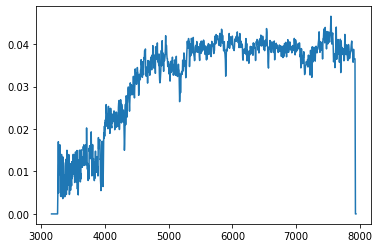

Number of capped errors 6756


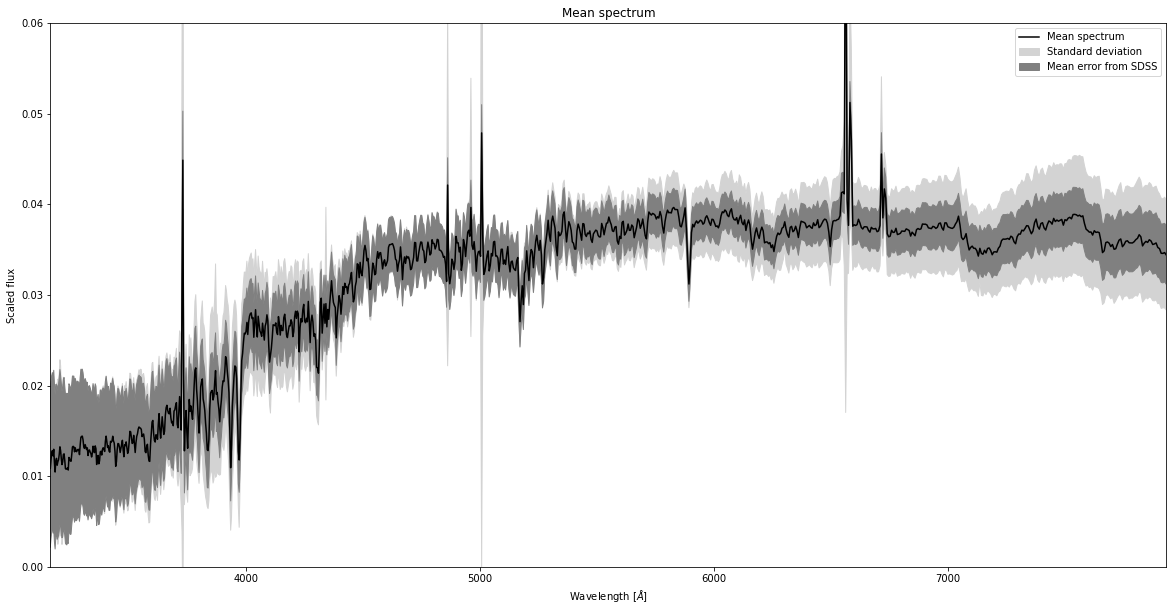

In [9]:
#%% Calculating wavlength grid from coefficients

log_wavelengths = data['coeff0'] + data['coeff1'] * np.arange(0, 1000, 1)
wavelengths = [10**i for i in log_wavelengths]

#%% Selecting only galaxies (spec_cln = 2)

galaxy_ind = data['spec_cln'] == 2
X = data['spectra'][galaxy_ind]
subclass = data['lineindex_cln'][galaxy_ind]
z = data['z'][galaxy_ind]
z_err = data['zerr'][galaxy_ind]
spec_err = data['spec_err'][galaxy_ind]

#%% Set any negative spikes in flux to zero and set the corresponding error to zero

neg_ind = X <= 0.
X[neg_ind] = 0.
spec_err[neg_ind] = 0.

#%% Set zero fluxes to NaN

X_nonan = X.copy()
zero_ind = X == 0.
X[zero_ind] = np.NaN

#%% Set all zero and negative flux errors to NaN

zero_err_ind = spec_err <= 0.
spec_err[zero_err_ind] = np.NaN

#%% Normalise spectrum
X_normal, norm = preprocessing.normalize(X_nonan, return_norm=True)
X_norm_zeros = np.copy(X_normal)

#%% Plot an example spectrum in the data
plt.figure()
plt.plot(wavelengths,X_normal[4])
plt.show()

#%% Set all zero normalised fluxes to nan
zero_norm_ind = X_normal == 0.
X_normal[zero_norm_ind] = np.NaN

#%% Transform errors due to corresponding normalisation
spec_err_T = np.transpose(spec_err)
spec_err_norm_T = np.divide(spec_err_T,norm)
spec_err_norm = np.transpose(spec_err_norm_T)

# %% Cap errors at a lower limit of 1e-5 times the flux
cap_counter = 0
for spectra in range(len(spec_err_norm)):
    for pixel in range(len(spec_err_norm[spectra])):
        if np.isnan(spec_err_norm[spectra][pixel]) == False and spec_err_norm[spectra][pixel] < 1e-5 * X_normal[spectra][pixel]:
            spec_err_norm[spectra][pixel] = 1e-5 * X_normal[spectra][pixel]
            cap_counter += 1
print("Number of capped errors", cap_counter)

#%% Spectra errors with infs instead of nans
spec_err_norm_inf = np.nan_to_num(spec_err_norm,nan=np.inf)

# Mask where errors are infinite
mask_err = np.zeros(np.shape(spec_err_norm), dtype=bool)
spec_err_inf_ind = spec_err_norm_inf == np.inf
mask_err[spec_err_inf_ind] = True

#%% Plot mean spectrum
mu = np.nanmean(X_normal, axis=0)
std = np.nanstd(X_normal, axis=0)
#mu = X_norm_zeros.mean(0)
#std = X_norm_zeros.std(0)
mean_err = np.nanmean(spec_err_norm, axis=0)
plt.figure(figsize=(20,10))
plt.plot(wavelengths, mu, color = 'black', label='Mean spectrum')
plt.fill_between(wavelengths, mu - std, mu + std , color = 'lightgrey', label='Standard deviation')
plt.fill_between(wavelengths, mu - mean_err, mu + mean_err , color = 'grey', label = 'Mean error from SDSS')
plt.xlim(wavelengths[0], wavelengths[-1])
plt.ylim(0,0.06)
plt.xlabel('Wavelength [$\AA$]')
plt.ylabel('Scaled flux')
plt.title('Mean spectrum')
plt.legend()
plt.show()

#%% Apply PCA
pca = PCA(n_components=4, random_state=0)
X_red = pca.fit_transform(X_norm_zeros)

#%% Fill spectra minus mean to be filled with zeros at nan values
X_mu = X_normal - mu
X_mu_zeros = np.nan_to_num(X_mu,nan=0.)

# Iterative PCA

In [10]:
!pip install astroML

     |████████████████████████████████| 112kB 19.3MB/s 
  Created wheel for astroML: filename=astroML-0.4.1-cp36-none-any.whl size=128665 sha256=7412a4a9d7bcd7cca2515065d74c74a726590e8d4ee592b9bd0c5729b8d9cc38
  Stored in directory: /root/.cache/pip/wheels/7c/f2/f3/eb817cfb31b4445358dd7dda2434e02003f72801edabc38c97
Successfully built astroML


In [11]:
from astroML.dimensionality import iterative_pca

In [12]:
X_recons, mu_iter, evecs, evals, norms, coeffs = iterative_pca(X_norm_zeros, mask_err, n_ev=4, n_iter=15, norm='L2', full_output=True)

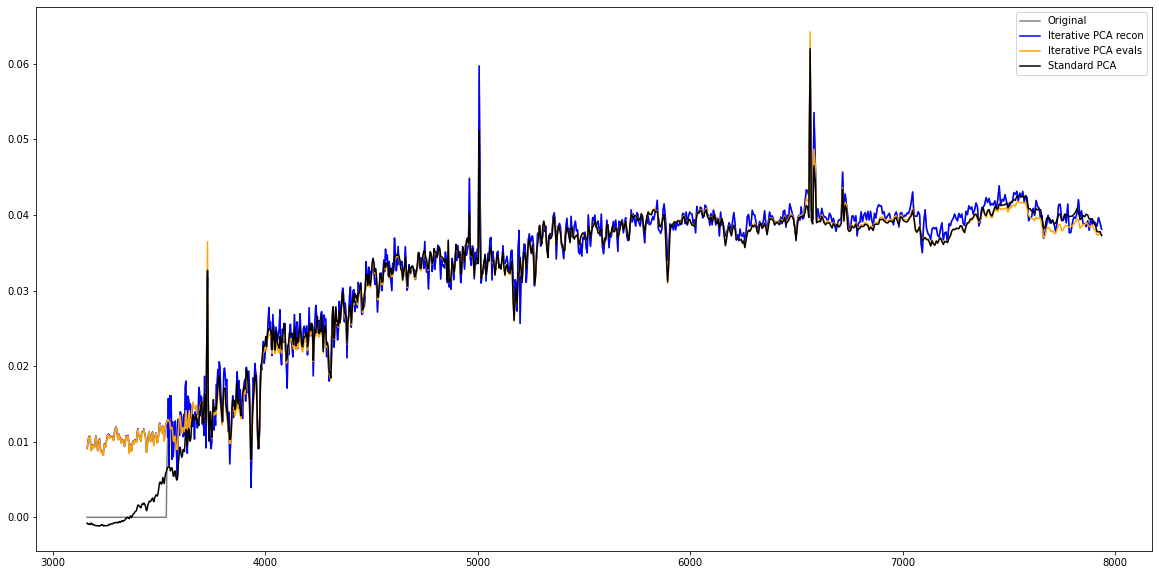

In [13]:
spectra_num = 100
n_ev = 4

plt.figure(figsize=(20,10))
plt.plot(wavelengths, X_norm_zeros[spectra_num], '-', c='gray', label='Original')

plt.plot(wavelengths, X_recons[spectra_num], '-b', label='Iterative PCA recon')
plt.plot(wavelengths, mu_iter + np.dot(coeffs[spectra_num], evecs[:n_ev]), '-',color='orange', label='Iterative PCA evals')
plt.plot(wavelengths, pca.mean_ + np.dot(X_red[spectra_num], pca.components_), '-k', label='Standard PCA')
plt.legend()
plt.show()

# Bayesian PCA

In [14]:
# Store W and ident (have to transpose because pca.components_ has different dimensions to W in the equations)
W = pca.components_.T 
ident = jnp.identity(W.shape[1])

In [15]:
def sig_inv_diag_all(spec_err_norm_inf):
  sig_inv_diag_arr = spec_err_norm_inf ** (-2)
  log_sig = np.log(sig_inv_diag_arr)
  log_sig[log_sig == -np.inf] = 0.
  logdet_sig_arr = np.array([np.sum(i) for i in log_sig])
  return sig_inv_diag_arr, logdet_sig_arr

In [16]:
sig_inv_diag_arr, logdet_sig_arr = sig_inv_diag_all(spec_err_norm_inf)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


In [17]:
def ln_onespec(W,ident, X_mu_zeros_n, sig_inv_diag, logdet_sig):
  sig_inv_W = sig_inv_diag[:,None]*W

  M = ident + jnp.matmul(W.T, sig_inv_W)
  M_inv = jnp.linalg.solve(M,ident)
  _, logdet_M = jnp.linalg.slogdet(M)

  W_sig = sig_inv_W.T
  W_sig_X = jnp.matmul(W_sig, X_mu_zeros_n)
  Minv_W_sig_X = jnp.matmul(M_inv, W_sig_X)
  Cinv_2 = jnp.matmul(sig_inv_W, Minv_W_sig_X)
  Cinv_1 = sig_inv_diag*X_mu_zeros_n
  Cinv_X = Cinv_1 - Cinv_2
    
  l_n = -0.5*X_mu_zeros_n.shape[0]*jnp.log(2*jnp.pi) -0.5*(logdet_M - logdet_sig) -0.5*jnp.matmul(X_mu_zeros_n.T, Cinv_X)  

  return l_n

In [18]:
def ln_allspec(W, data1):
  ident, X_mu_zeros, sig_inv_diag_arr, logdet_sig_arr = data1
  W = W[0]
  return -sum(vmap(ln_onespec, in_axes=(None,None,0,0,0))(W, ident, X_mu_zeros, sig_inv_diag_arr, logdet_sig_arr))

In [19]:
data1 = (ident, X_mu_zeros, sig_inv_diag_arr, logdet_sig_arr)
ln_allspec([1*W], data1)

908118619009.6592

In [20]:
data1 = (ident, X_mu_zeros, sig_inv_diag_arr, logdet_sig_arr)
ln_allspec([1*W], data1)

908118619009.6592

In [21]:
print(W)

[[ 0.00263145  0.02302115  0.004422   -0.00635522]
 [ 0.00275811  0.02596738  0.00465356 -0.00696755]
 [ 0.00291664  0.02785674  0.00527492 -0.00748549]
 ...
 [-0.02643922 -0.142731   -0.04825715  0.0184192 ]
 [-0.02639044 -0.1443583  -0.04803315  0.01410202]
 [-0.02531817 -0.14321849 -0.04861543  0.01278134]]


In [22]:
from jax.experimental import optimizers
param_list = [1*W]
learning_rate = 1e-5
opt_init, opt_update, get_params = jax.experimental.optimizers.adam(learning_rate)
opt_state = opt_init(param_list)

@jit
def update(step, opt_state, data1):
  params = get_params(opt_state)
  value, grads = jax.value_and_grad(ln_allspec)(params,data1)
  opt_state = opt_update(step, grads, opt_state)
  return value, opt_state

num_iterations = 10

data1 = (ident, jnp.array(X_mu_zeros), jnp.array(sig_inv_diag_arr), jnp.array(logdet_sig_arr))
for step in range(num_iterations):
  # Could potentially also iterate over batches of data
  loss_value, opt_state = update(step, opt_state, data1)

# optimised matrix:
W_new_optimised = get_params(opt_state)

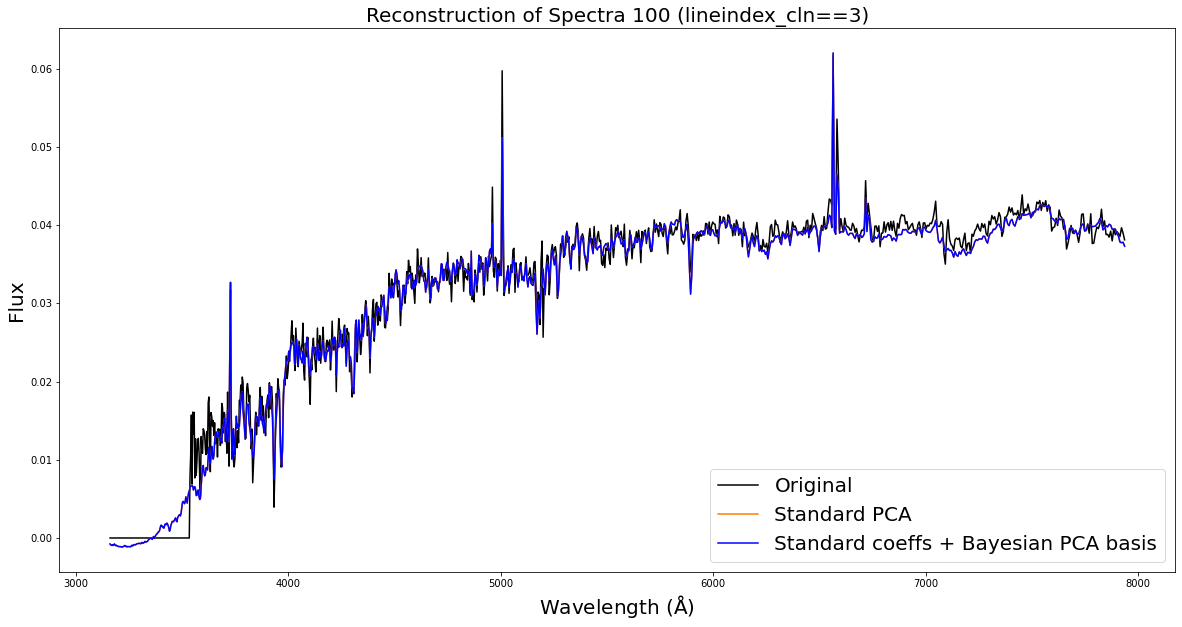

In [23]:
spectra_num = 100
fig = plt.figure(figsize=(20,10))
plt.plot(wavelengths, X_norm_zeros[spectra_num], '-k', label='Original')
plt.plot(wavelengths, pca.mean_ + np.dot(X_red[spectra_num], pca.components_), c='#ff7f00', label='Standard PCA')
plt.plot(wavelengths, pca.mean_ + np.dot(X_red[spectra_num], np.array(W_new_optimised[0]).T), '-b', label='Standard coeffs + Bayesian PCA basis')
plt.ylabel('Flux', fontsize=20)
plt.xlabel(r'${\rm Wavelength\ (\AA)}$', fontsize=20)
plt.title(f'Reconstruction of Spectra {spectra_num} (lineindex_cln=={subclass[spectra_num]})', fontsize=20)
plt.legend(fontsize=20)
plt.show()

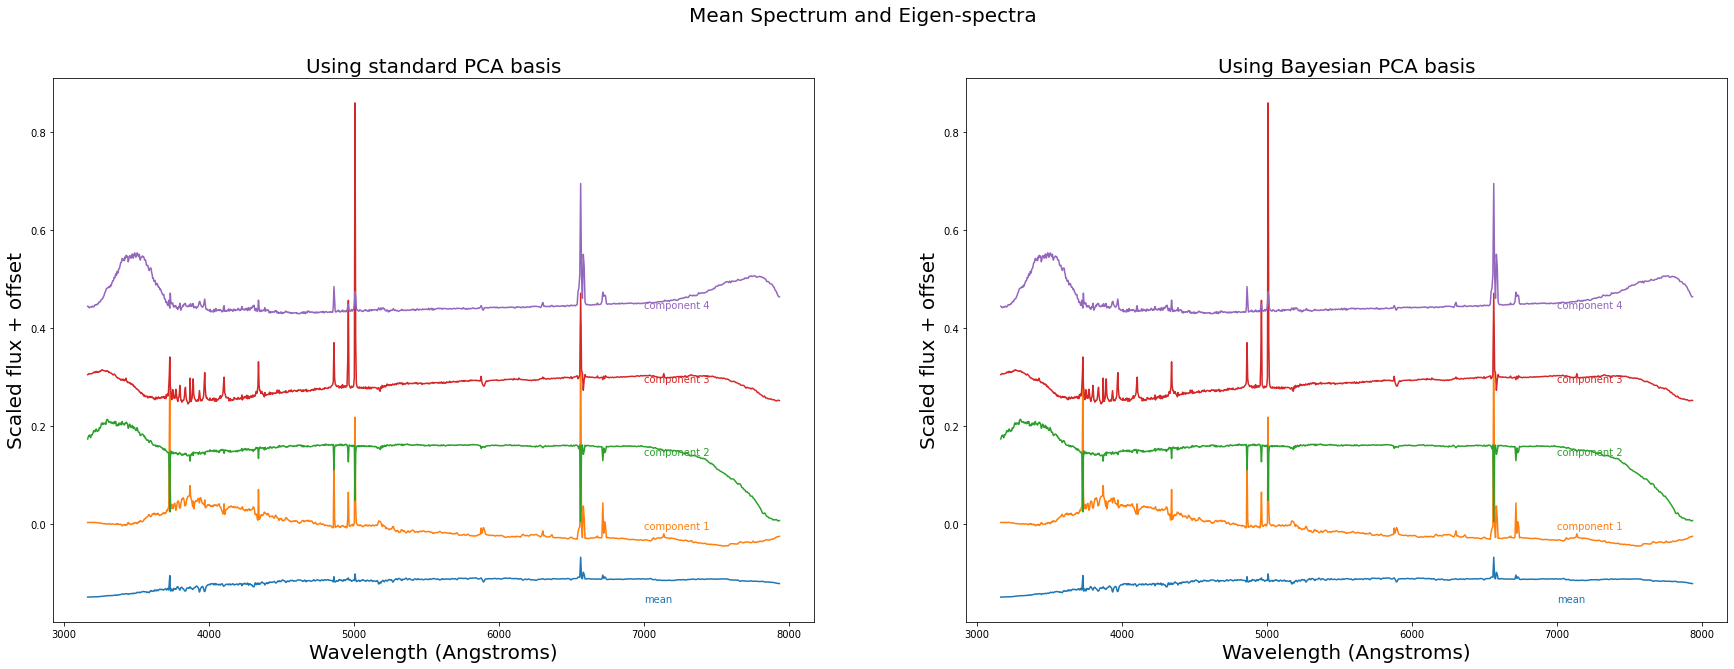

In [130]:
# Plot the mean spectrum and the first four eigenvectors of the spectral data
fig, axs = plt.subplots(1, 2, figsize=(30,10))
l = axs[0].plot(wavelengths, pca.mean_ - 0.15)
axs[1].plot(wavelengths, pca.mean_ - 0.15)
c = l[0].get_color()
axs[0].text(7000, -0.16, "mean", color=c)
axs[1].text(7000, -0.16, "mean", color=c)
for i in range(4):
    l = axs[0].plot(wavelengths, pca.components_[i] + 0.15 * i)
    axs[1].plot(wavelengths, W_optimised_arr.T[i] + 0.15 * i)
    c = l[0].get_color()
    axs[0].text(7000, -0.01 + 0.15 * i, "component %i" % (i + 1), color=c)
    axs[1].text(7000, -0.01 + 0.15 * i, "component %i" % (i + 1), color=c)
#plt.ylim(-0.2, 0.6)
axs[0].set_xlabel('Wavelength (Angstroms)', fontsize=20)
axs[1].set_xlabel('Wavelength (Angstroms)', fontsize=20)
axs[0].set_ylabel('Scaled flux + offset', fontsize=20)
axs[1].set_ylabel('Scaled flux + offset', fontsize=20)
plt.suptitle('Mean Spectrum and Eigen-spectra', fontsize=20)
axs[0].set_title('Using standard PCA basis', fontsize=20)
axs[1].set_title('Using Bayesian PCA basis', fontsize=20)
plt.show()

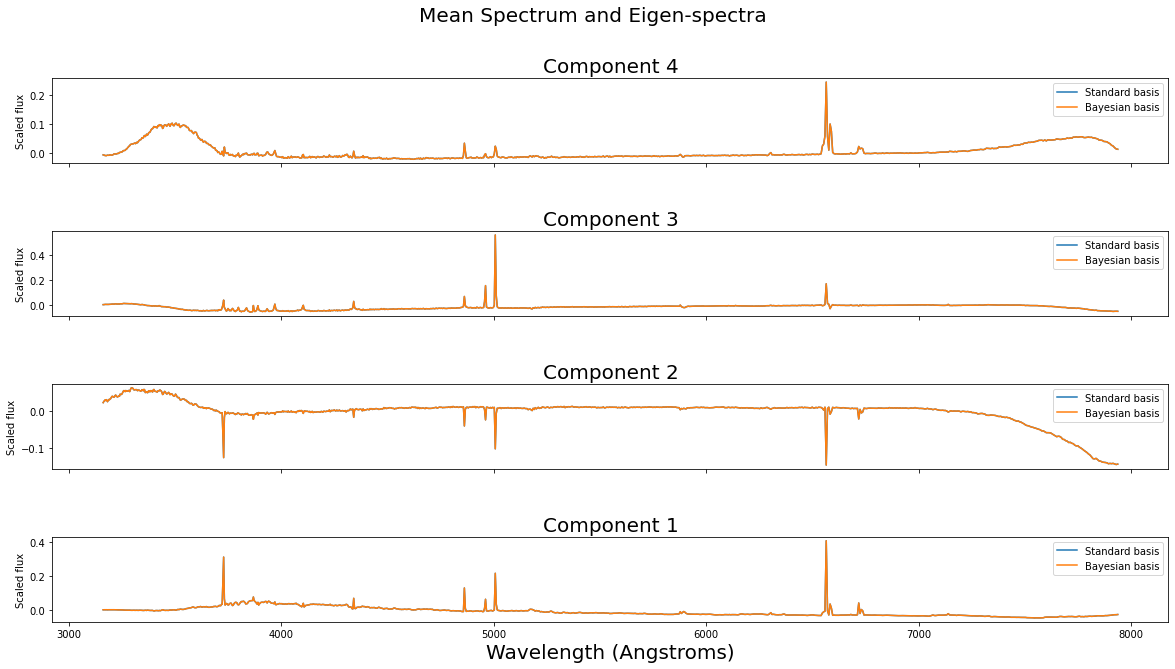

In [145]:
# Plot the mean spectrum and the first four eigenvectors of the spectral data
fig, axs = plt.subplots(4, sharex=True, figsize=(20,10))
for i in range(len(pca.components_)):
  axs[i].plot(wavelengths, W_optimised_arr.T[3-i], label='Standard basis')
  axs[i].plot(wavelengths, pca.components_[3-i], label='Bayesian basis')
  axs[i].legend()
  axs[i].set_ylabel('Scaled flux')
  axs[i].set_title(f'Component {3-i+1}', fontsize=20)
axs[3].set_xlabel('Wavelength (Angstroms)', fontsize=20)
plt.suptitle('Mean Spectrum and Eigen-spectra', fontsize=20)
plt.subplots_adjust(hspace=.8, wspace=.2)
plt.show()

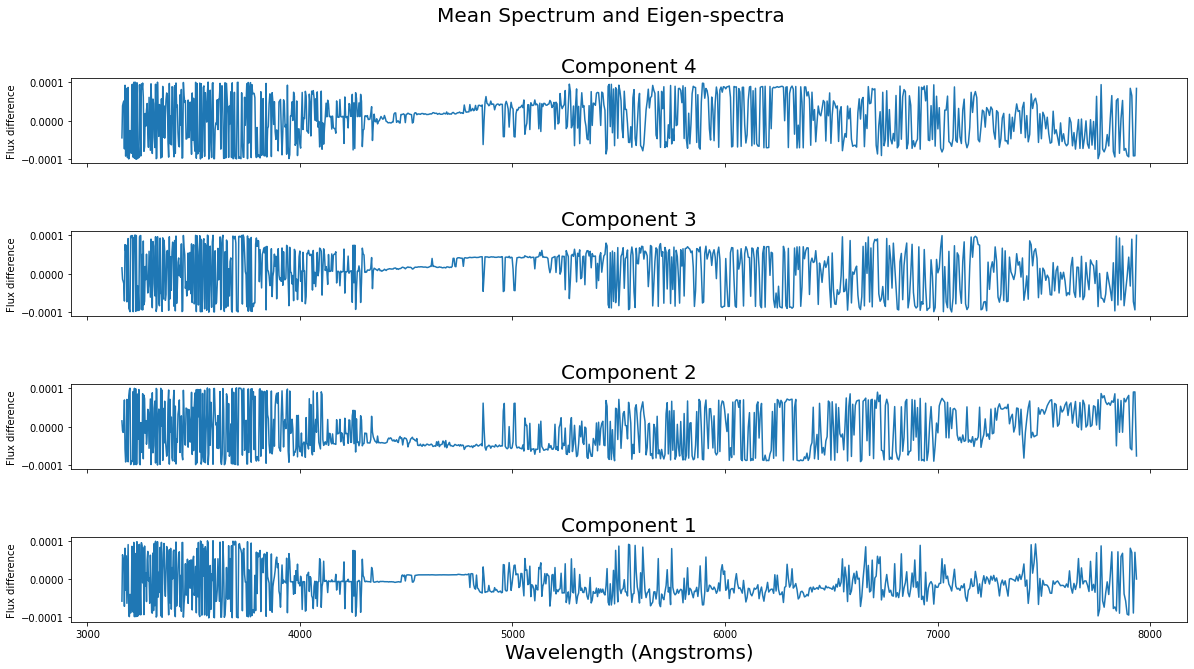

In [146]:
# Plot the mean spectrum and the first four eigenvectors of the spectral data
fig, axs = plt.subplots(4, sharex=True, figsize=(20,10))
for i in range(len(pca.components_)):
  axs[i].plot(wavelengths, W_optimised_arr.T[3-i]-pca.components_[3-i])
  axs[i].set_ylabel('Flux difference')
  axs[i].set_title(f'Component {3-i+1}', fontsize=20)
axs[3].set_xlabel('Wavelength (Angstroms)', fontsize=20)
plt.suptitle('Mean Spectrum and Eigen-spectra', fontsize=20)
plt.subplots_adjust(hspace=.8, wspace=.2)
plt.show()

# Bayesian coefficients

In [24]:
# Function to retrieve PCA coefficients from a PCA
def bayesian_coeffs(W, X_mu_zeros_n, sig_inv_diag, ident):
  W_siginv_X = np.matmul(W.T,sig_inv_diag*X_mu_zeros_n)
  M = np.matmul(W.T, sig_inv_diag[:, None]*W) + ident
  z_map = np.linalg.solve(M, W_siginv_X)
  return z_map

In [25]:
# Retrieve coefficients for all arrays
W_optimised_arr = np.asarray(W_new_optimised[0])
coeffs_optimised = np.zeros(4)
for i in range(X_mu_zeros.shape[0]):
  coeffs_optimised = np.vstack((coeffs_optimised, bayesian_coeffs(W_optimised_arr, X_mu_zeros[i],sig_inv_diag_arr[i], ident)))

coeffs_optimised = np.delete(coeffs_optimised, 0, 0)

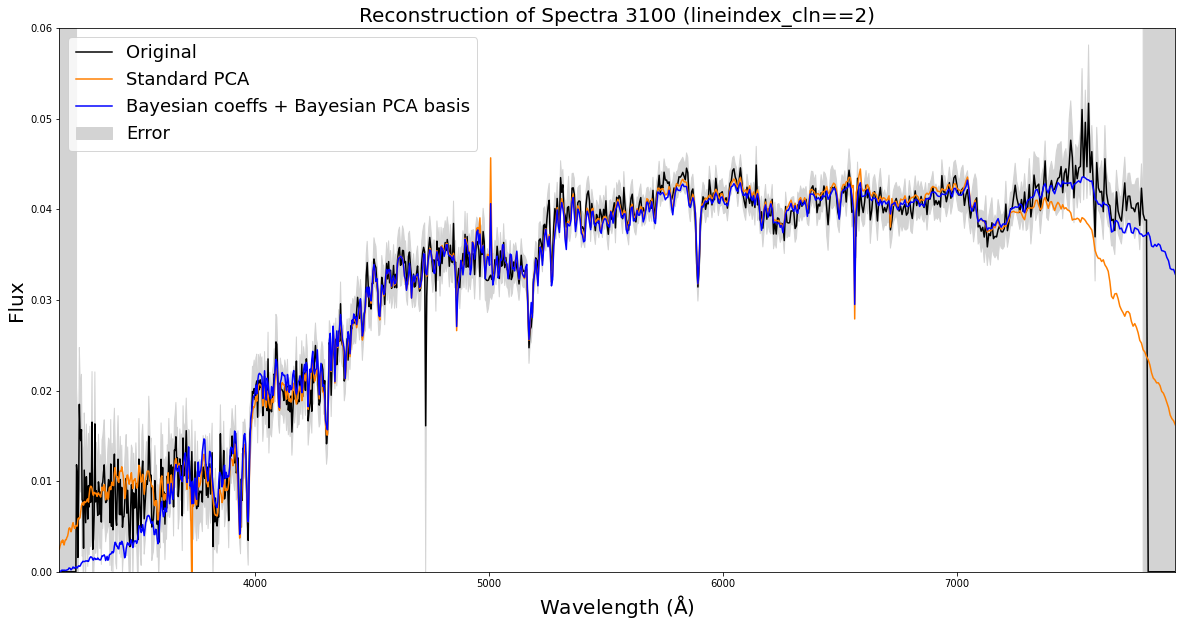

In [26]:
spec_num = 3100
fig = plt.figure(figsize=(20,10))

plt.plot(wavelengths, X_norm_zeros[spec_num], '-k', label='Original')
plt.plot(wavelengths, pca.mean_ + np.dot(X_red[spec_num], pca.components_), c='#ff7f00', label='Standard PCA')
#plt.plot(wavelengths, pca.mean_ + np.dot(bayesian_coeffs(W, X_mu_zeros[spec_num],sig_inv_diag_arr[spec_num], ident), W.T), '-b', label='Bayesian coeffs + standard PCA basis')
#plt.plot(wavelengths, pca.mean_ + np.dot(X_red[spec_num], np.array(W_new_optimised[0]).T), '-b', label='Standard coeffs + Bayesian PCA basis')
plt.plot(wavelengths, pca.mean_ + np.dot(coeffs_optimised[spec_num], W_optimised_arr.T), '-b', label='Bayesian coeffs + Bayesian PCA basis')

spec_err_norm_large = np.copy(spec_err_norm_inf)
spec_err_norm_large[spec_err_norm_large==np.inf] = 10
plt.fill_between(wavelengths, X_norm_zeros[spec_num] - spec_err_norm_large[spec_num], X_norm_zeros[spec_num] + spec_err_norm_large[spec_num] , color = 'lightgrey', label='Error')
#plt.plot(wavelengths,spec_err_norm_large[spec_num], color='orange', label='Error')
#plt.fill_between(wavelengths, X_norm_zeros[spec_num] - spec_err_norm_inf[spec_num], X_norm_zeros[spec_num] + spec_err_norm_inf[spec_num] , color = 'lightgrey', label='Error')
#plt.plot(wavelengths,spec_err_norm_inf[spec_num], color='orange', label='Error')
plt.ylim(0,0.06)
plt.xlim(wavelengths[0],wavelengths[-1])

plt.ylabel('Flux', fontsize=20)
plt.xlabel(r'${\rm Wavelength\ (\AA)}$', fontsize=20)
plt.title(f'Reconstruction of Spectra {spec_num} (lineindex_cln=={subclass[spec_num]})', fontsize=20)
plt.legend(fontsize=18)
plt.show()

In [27]:
np.save('W_new_optimised_10iter_1e-5lr.npy', np.asarray(W_new_optimised[0]))

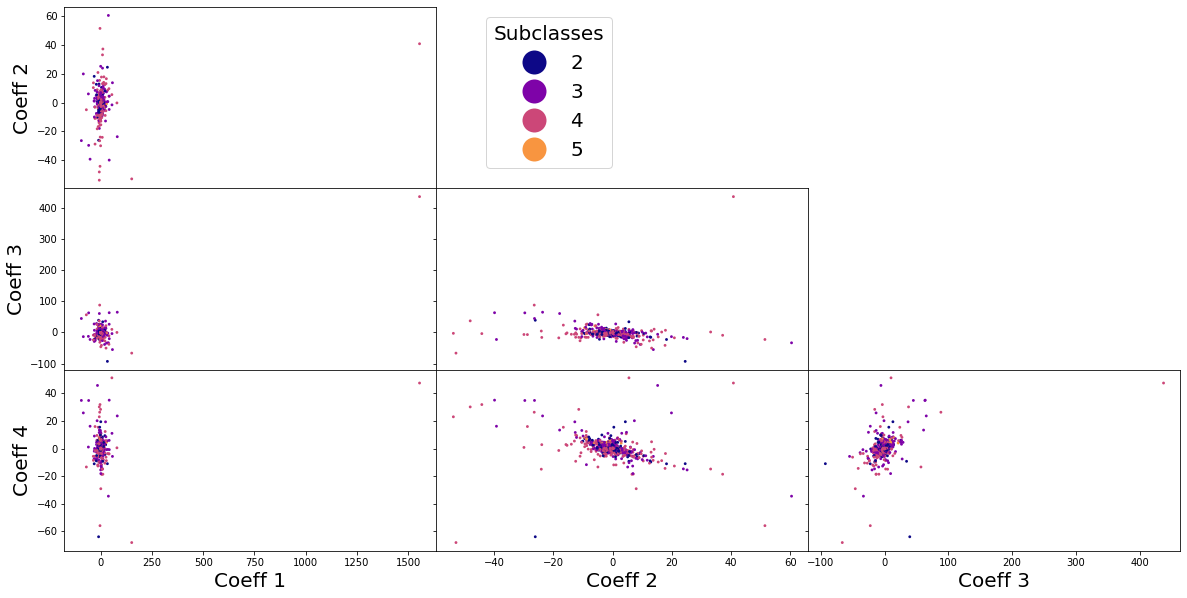

In [28]:
# Plotting optimised Bayesian coefficients against each other
plt.figure(figsize=(20,10))
plt.rc('xtick',labelsize=10)
plt.rc('ytick',labelsize=10)
plt.set_cmap('plasma')

ax1 = plt.subplot(3,3,1)
scatter1 = ax1.scatter(coeffs_optimised[:, 0], coeffs_optimised[:, 1], c = subclass, s=8, lw=0, vmin=2, vmax=6)
ax1.set_ylabel('Coeff 2', fontsize=20)

ax2 = plt.subplot(3,3,4)
ax2.scatter(coeffs_optimised[:, 0], coeffs_optimised[:, 2], c = subclass, s=8, lw=0, vmin=2, vmax=6)
ax2.set_ylabel('Coeff 3', fontsize=20)

ax3 = plt.subplot(3,3,5)
ax3.scatter(coeffs_optimised[:, 1], coeffs_optimised[:, 2], c = subclass, s=8, lw=0, vmin=2, vmax=6)

ax4 = plt.subplot(3,3,7)
ax4.scatter(coeffs_optimised[:, 0], coeffs_optimised[:, 3], c = subclass, s=8, lw=0, vmin=2, vmax=6)
ax4.set_xlabel('Coeff 1', fontsize=20)
ax4.set_ylabel('Coeff 4', fontsize=20)

ax5 = plt.subplot(3,3,8)
ax5.scatter(coeffs_optimised[:, 1], coeffs_optimised[:, 3], c = subclass, s=8, lw=0, vmin=2, vmax=6)
ax5.set_xlabel('Coeff 2', fontsize=20)

ax6 = plt.subplot(3,3,9)
ax6.scatter(coeffs_optimised[:, 2], coeffs_optimised[:, 3], c = subclass, s=8, lw=0, vmin=2, vmax=6)
ax6.set_xlabel('Coeff 3', fontsize=20)

plt.subplots_adjust(hspace=.0, wspace=.0)
axs = np.array([ax1, ax2, ax3, ax4, ax5, ax6])
for ax in axs.flat:
    ax.label_outer()
    
ax1.legend(*scatter1.legend_elements(), bbox_to_anchor=(1.5, 1), title="Subclasses",
                     fontsize=20, title_fontsize=20, markerscale=4)

plt.show()

# Chi-squared values

In [29]:
def calculate_allchi(original, mean, coeffs, components, noise):
  chi_arr = np.zeros(original.shape[1])
  for spec_num in range(len(original)):
    reconstruction = mean + np.dot(coeffs[spec_num], components)
    chi = ((reconstruction - original[spec_num]) / noise[spec_num]) ** 2
    chi_arr = np.vstack((chi_arr, chi))
  chi_arr = np.delete(chi_arr, 0, 0)
  #chi_arr[chi_arr == 0.] = np.nan

  return chi_arr

In [30]:
chi_bayesian_noop = calculate_allchi(X_norm_zeros, pca.mean_, X_red,  W_optimised_arr.T, spec_err_norm)
chi_bayesian_op = calculate_allchi(X_norm_zeros, pca.mean_, coeffs_optimised, W_optimised_arr.T, spec_err_norm)

In [31]:
chi_per_spectra_bayesian_noop = np.nansum(chi_bayesian_noop, axis=1)/np.count_nonzero(~np.isnan(chi_bayesian_noop), axis=1)
chi_per_spectra_bayesian_op = np.nansum(chi_bayesian_op, axis=1)/np.count_nonzero(~np.isnan(chi_bayesian_op), axis=1)

In [32]:
chi_per_pixel_mean_bayesian_noop = np.nanmean(chi_bayesian_noop ** 0.5, axis=0)
chi_per_pixel_mean_bayesian_op = np.nanmean(chi_bayesian_op ** 0.5, axis=0)
chi_per_pixel_var_bayesian_noop = np.nanvar(chi_bayesian_noop ** 0.5, axis=0)
chi_per_pixel_var_bayesian_op = np.nanvar(chi_bayesian_op ** 0.5, axis=0)
num_validpix_per_pixel = np.count_nonzero(~np.isnan(chi_bayesian_noop), axis=0)

## Chi-squared values for Bayesian PCA

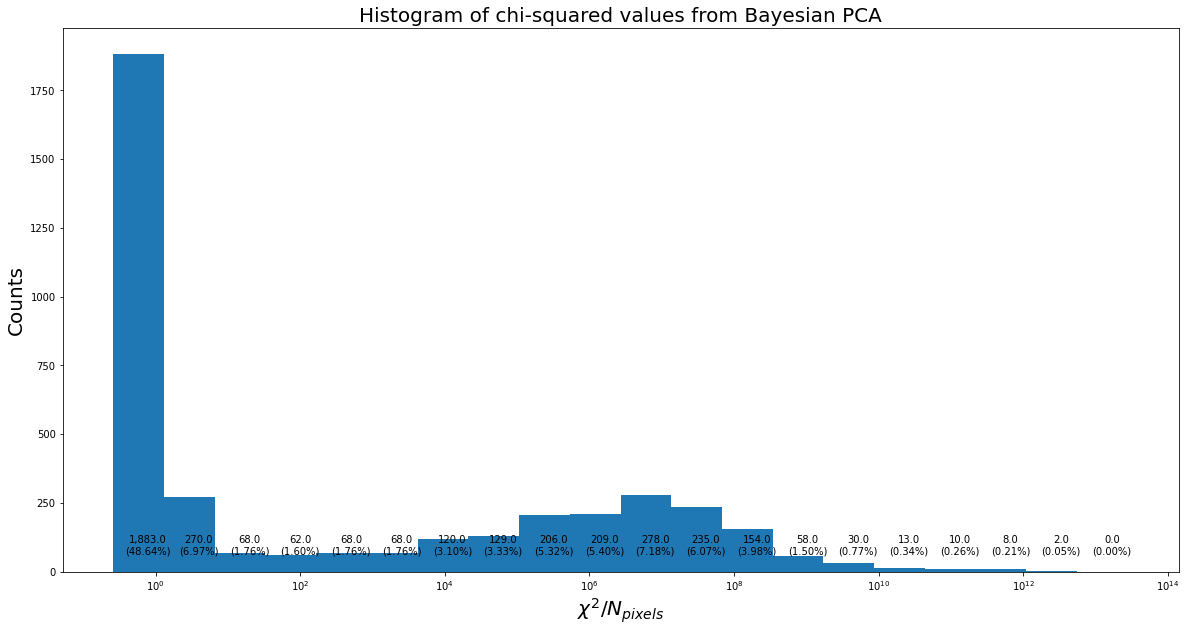

In [55]:
# %% Plot chi-squared values
# Code adapted from https://towardsdatascience.com/advanced-histogram-using-python-bceae288e715
fig, ax = plt.subplots(figsize=(20,10))
_, bins = np.histogram(chi_per_spectra_bayesian_op, bins=20)

# Plot histogram on log scale
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
logcounts, _, _ = ax.hist(chi_per_spectra_bayesian_op, bins=logbins)
ax.set_xscale('log')
        
# Calculate bar centre to display the count of data points and %
bin_x_centers = 0.5 * np.diff(logbins) + logbins[:-1]
bin_y_centers = ax.get_yticks()[1] * 0.25

# Display the the count of data points and % for each bar in histogram
for i in range(len(bins)-1):
    bin_label = "{0:,}".format(logcounts[i]) + "\n({0:,.2f}%)".format((logcounts[i]/logcounts.sum())*100)    
    ax.text(bin_x_centers[i], bin_y_centers, bin_label, horizontalalignment='center')    

plt.title('Histogram of chi-squared values from Bayesian PCA', fontsize=20)
plt.xlabel("$\chi^2/N_{pixels}$", fontsize=20)
plt.ylabel('Counts',fontsize=20)
plt.show()

Histogram of chi squared values from standard PCA
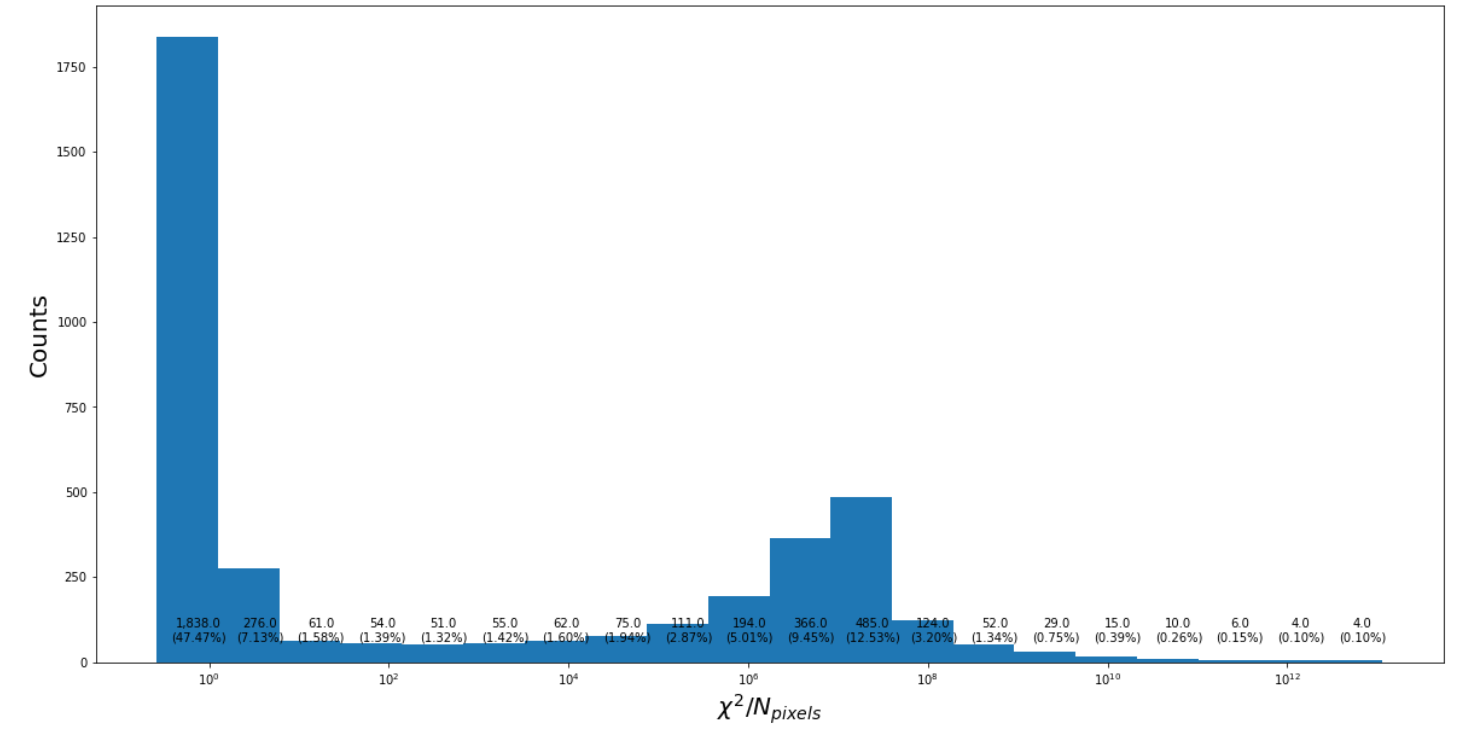

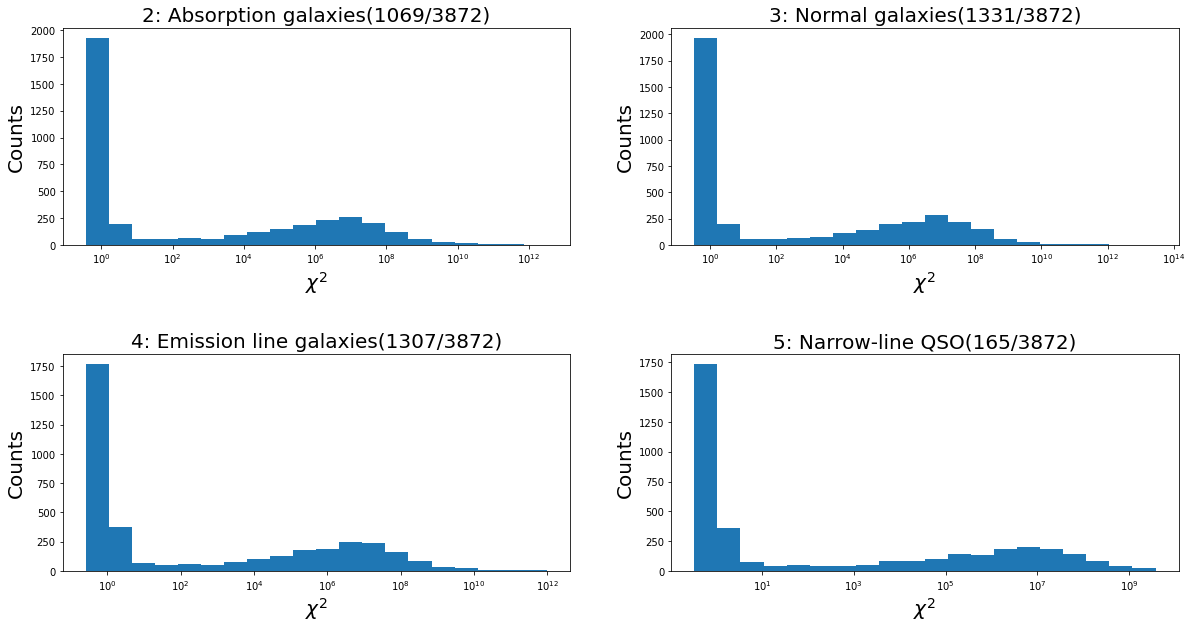

In [34]:
# %% Plot chi-squared value histograms for each subclass
plt.figure(figsize=(20,10))
subclass_names = ['2: Absorption galaxies', '3: Normal galaxies', '4: Emission line galaxies', '5: Narrow-line QSO']
for i in range(4):
    ax = plt.subplot(221 + i)
    _, bins = np.histogram(chi_per_spectra_bayesian_op[subclass==i+2], bins=20)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    logcounts, _, _ = ax.hist(chi_per_spectra_bayesian_op, bins=logbins)
    ax.set_xscale('log')
    bin_x_centers = 0.5 * np.diff(logbins) + logbins[:-1]
    bin_y_centers = ax.get_yticks()[1] * 0.25 
#    for j in range(len(bins)-1):
#        bin_label = "{0:,}".format(logcounts[j]) + "\n({0:,.2f}%)".format((logcounts[j]/logcounts.sum())*100)    
#        ax.text(bin_x_centers[j], bin_y_centers, bin_label, horizontalalignment='center')
    ax.set_xlabel("$\chi^2$", fontsize=20)
    ax.set_ylabel('Counts',fontsize=20)
    ax.set_title(f'{subclass_names[i]}({len(chi_per_spectra_bayesian_op[subclass==i+2])}/{len(subclass)})', fontsize=20)
plt.subplots_adjust(hspace=.5, wspace=.2)
plt.show()

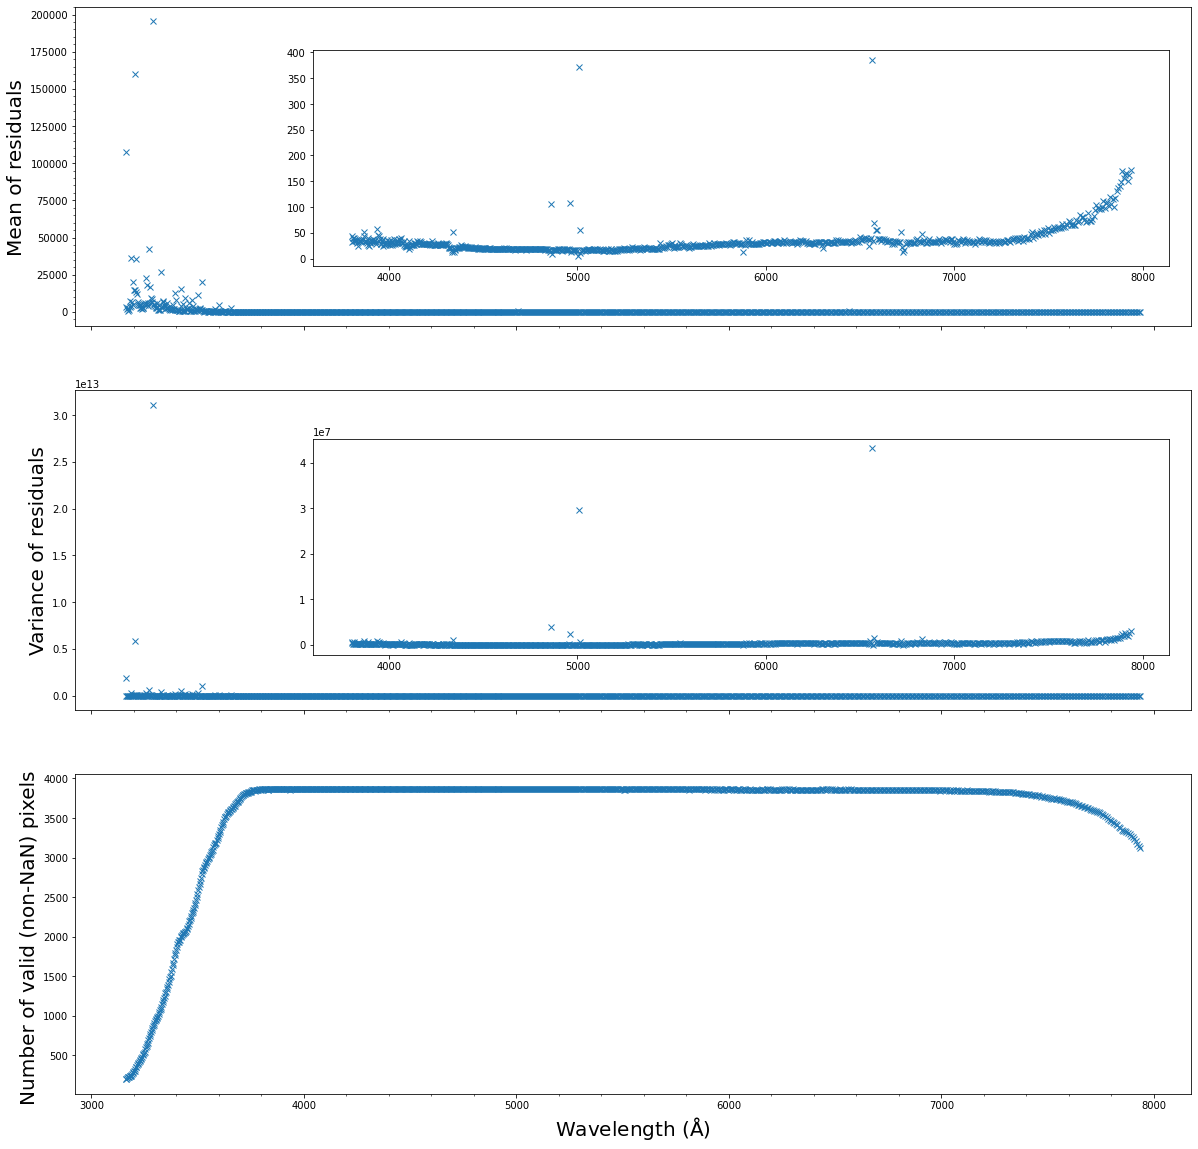

In [35]:
# %% Plot mean and variance of residuals, and number of valid pixels used
end_num = 200
fig, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True, figsize=(20,20))

ax1.plot(wavelengths, chi_per_pixel_mean_bayesian_op ,'x')
ax1.minorticks_on()
axins1 = fig.add_axes([0.29, 0.7, 0.595, 0.15])
axins1.plot(wavelengths[end_num:],chi_per_pixel_mean_bayesian_op[end_num:], 'x')
ax1.set_ylabel("Mean of residuals", fontsize=20)

ax2.plot(wavelengths,chi_per_pixel_var_bayesian_op,'x')
axins2 = fig.add_axes([0.29, 0.43, 0.595, 0.15])
axins2.plot(wavelengths[end_num:],chi_per_pixel_var_bayesian_op[end_num:], 'x')
ax2.set_ylabel("Variance of residuals", fontsize=20)

ax3.plot(wavelengths, num_validpix_per_pixel, 'x')
ax3.set_ylabel("Number of valid (non-NaN) pixels ", fontsize=20)
ax3.set_xlabel(r'${\rm Wavelength\ (\AA)}$', fontsize=20)
plt.show()

Mean and variance of residuals for standard PCA
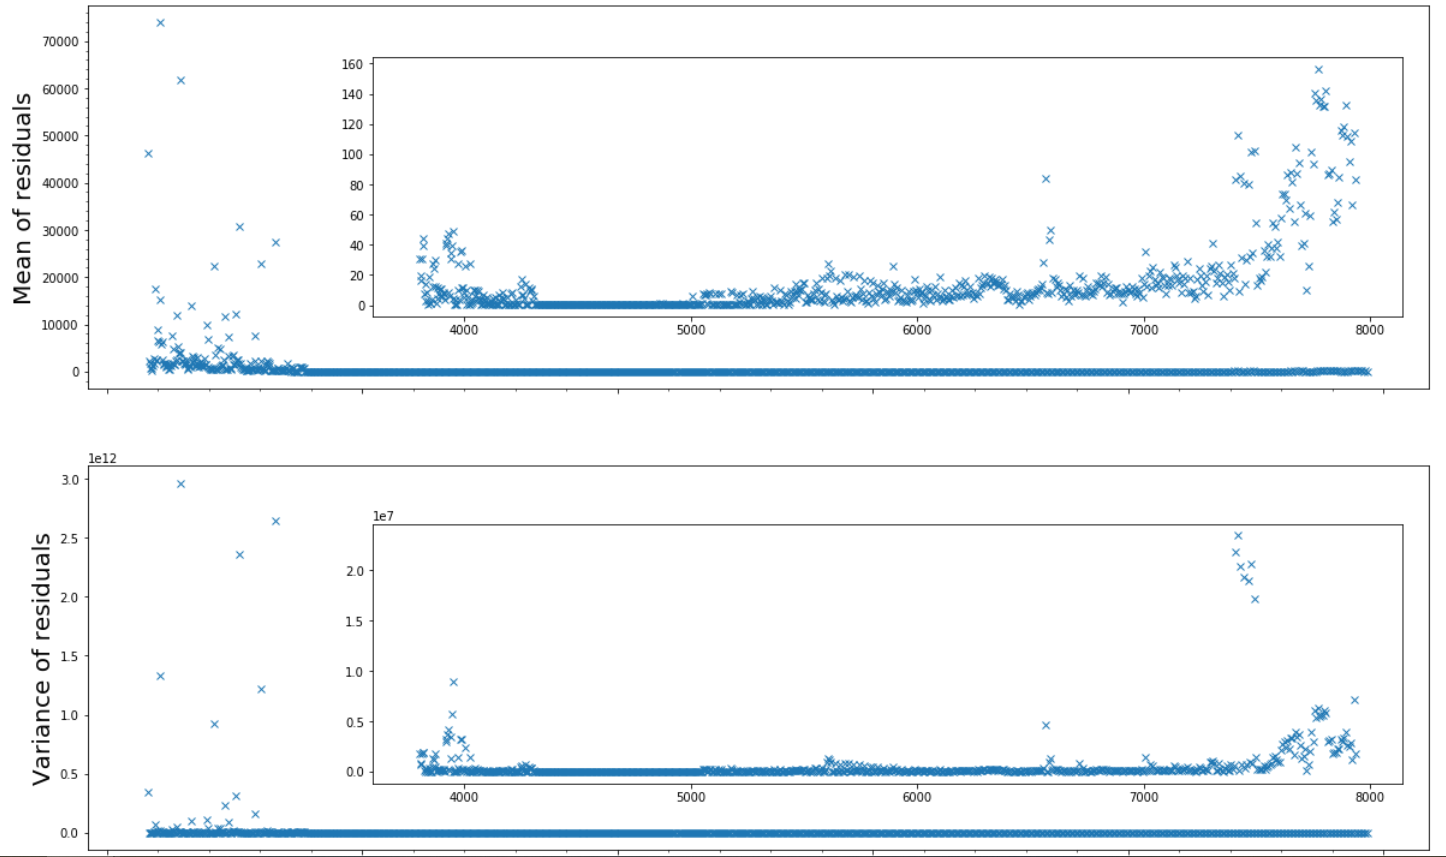

## Comparing change in chi-squared values for Bayesian PCA with unoptimised coeffcients vs optimised coefficients

In [36]:
chi_percent_diff = (chi_per_spectra_bayesian_op-chi_per_spectra_bayesian_noop)/chi_per_spectra_bayesian_noop

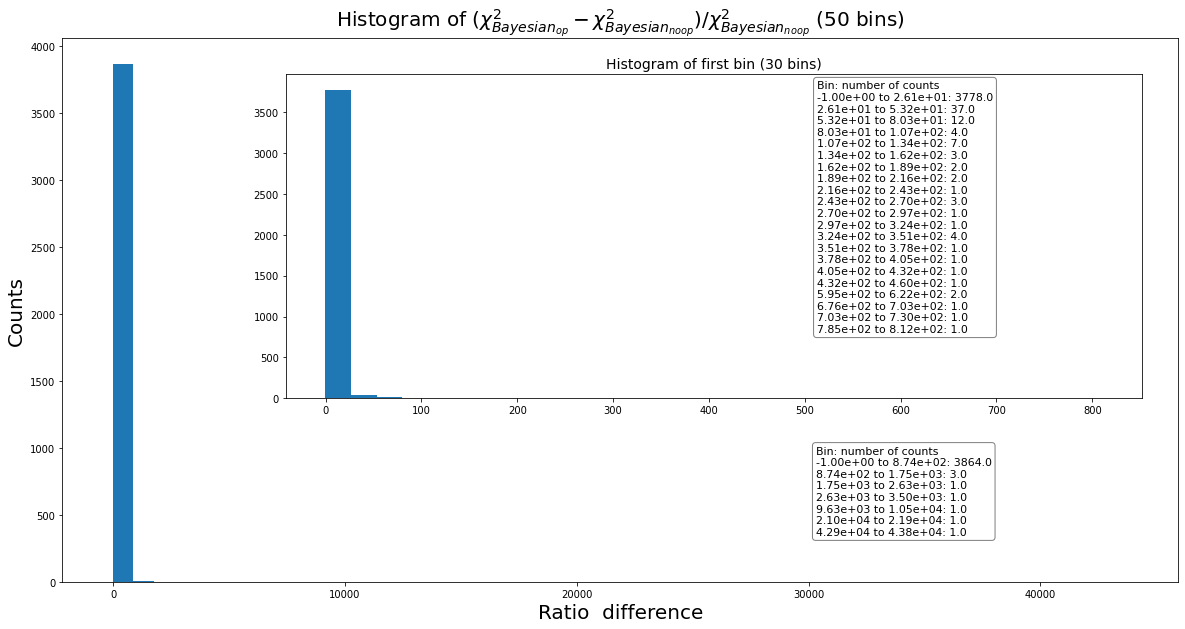

In [67]:
fig, ax = plt.subplots(figsize=(20,10))
counts, bins, _ = ax.hist(chi_percent_diff, bins=50)
text = 'Bin: number of counts\n'
for i in range(len(bins)-1):
    if counts[i]!= 0:
      text += f'{bins[i]:.2e} to {bins[i+1]:.2e}: {counts[i]}\n'
text = text[:-1]
ax.text(0.675, 0.25, text, transform=ax.transAxes, fontsize=11, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
axins = fig.add_axes([0.28, 0.38, 0.595, 0.45])
counts_axins, bins_axins, _ = axins.hist(chi_percent_diff[chi_percent_diff < bins[1]], bins=30)
text_axins = 'Bin: number of counts\n'
for i in range(len(bins_axins)-1):
    if counts_axins[i]!= 0:
      text_axins += f'{bins_axins[i]:.2e} to {bins_axins[i+1]:.2e}: {counts_axins[i]}\n'
text_axins = text_axins[:-1]
axins.text(0.62, 0.98, text_axins, transform=axins.transAxes, fontsize=11, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
axins.set_title('Histogram of first bin (30 bins)', fontsize=14)
ax.set_title('Histogram of $(\chi^2_{Bayesian_{op}} - \chi^2_{Bayesian_{noop}})/\chi^2_{Bayesian_{noop}}$ (50 bins)', fontsize=20)
ax.set_xlabel('Ratio  difference', fontsize=20)
ax.set_ylabel('Counts', fontsize=20)
plt.show()

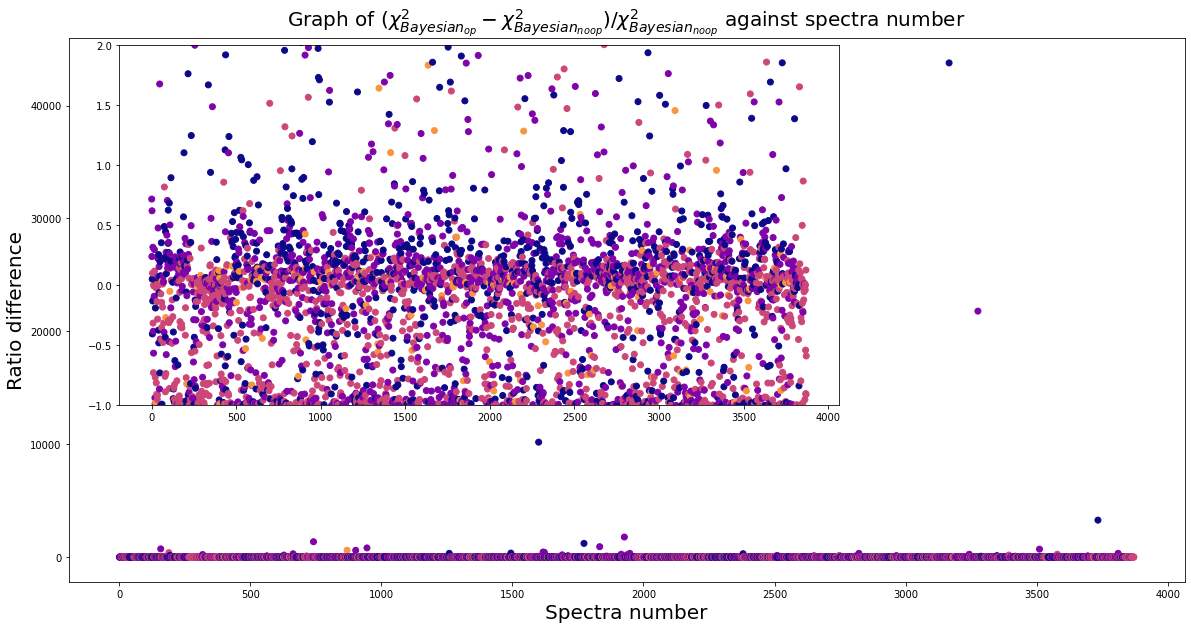

In [68]:
fig, ax = plt.subplots(figsize=(20,10))
ax.scatter(np.arange(len(chi_per_spectra_bayesian_noop)), chi_percent_diff, c=subclass, vmin=2, vmax=6)
axins = fig.add_axes([0.16, 0.37, 0.5, 0.5])
axins.scatter(np.arange(len(chi_per_spectra_bayesian_noop)), chi_percent_diff, c=subclass, vmin=2, vmax=6)
axins.set_ylim(-1,2)
ax.set_xlabel('Spectra number', fontsize=20)
ax.set_ylabel('Ratio difference', fontsize=20)
ax.set_title('Graph of $(\chi^2_{Bayesian_{op}} - \chi^2_{Bayesian_{noop}})/\chi^2_{Bayesian_{noop}}$ against spectra number', fontsize=20)
plt.show()

In [90]:
def plot_chi_change_bar_log(chi_percent_diff, title=''):
  from collections import OrderedDict
  chi_percent_diff_dict = OrderedDict()
  from math import log10
  chi_percent_diff_dict['<=0'] = len(chi_percent_diff[chi_percent_diff<=0.])
  chi_percent_diff_dict['[0,1)'] = len(chi_percent_diff[(chi_percent_diff>0.) & (chi_percent_diff<1.)])
  for i in range(int(log10(max(chi_percent_diff)))+1):
    if i == int(log10(max(chi_percent_diff))):
      chi_percent_diff_dict[f'[{10**i:.0e},{max(chi_percent_diff):.0e})'] = len(chi_percent_diff[(chi_percent_diff>10**i) & (chi_percent_diff<10**(i+1))])
    else:
      chi_percent_diff_dict[f'[{10**i:.0e},{10**(i+1):.0e})'] = len(chi_percent_diff[(chi_percent_diff>10**i) & (chi_percent_diff<10**(i+1))])

  #https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py
  fig, ax = plt.subplots(figsize=(20,10))
  bars = ax.bar(chi_percent_diff_dict.keys(), chi_percent_diff_dict.values())
  def autolabel(rects):
      """Attach a text label above each bar in *rects*, displaying its height."""
      for rect in rects:
          height = rect.get_height()
          ax.annotate('{}'.format(height),
                      xy=(rect.get_x() + rect.get_width() / 2, height),
                      xytext=(0, 3),  # 3 points vertical offset
                      textcoords="offset points",
                      ha='center', va='bottom')
  autolabel(bars)
  ax.set_xlabel('Ratio difference', fontsize=20)
  ax.set_ylabel('Counts', fontsize=20)
  ax.set_title(f'Bar graph showing distribution of {title}', fontsize=20)
  plt.show()
  return chi_percent_diff_dict

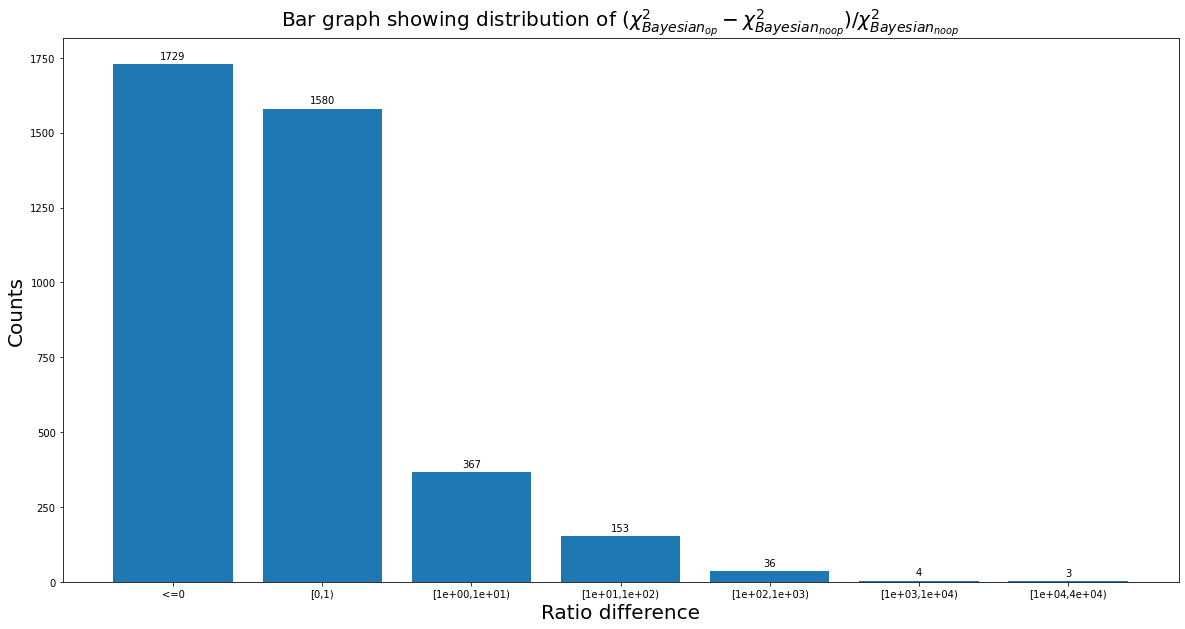

In [92]:
chi_percent_diff = (chi_per_spectra_bayesian_op-chi_per_spectra_bayesian_noop)/chi_per_spectra_bayesian_noop
chi_percent_diff_dict = plot_chi_change_bar_log(chi_percent_diff, title='$(\chi^2_{Bayesian_{op}} - \chi^2_{Bayesian_{noop}})/\chi^2_{Bayesian_{noop}}$')

In [87]:
chi_per_pixel_mean_diff = (chi_per_pixel_mean_bayesian_op-chi_per_pixel_mean_bayesian_noop)/chi_per_pixel_mean_bayesian_noop
chi_per_pixel_var_diff = (chi_per_pixel_var_bayesian_op-chi_per_pixel_var_bayesian_noop)/chi_per_pixel_var_bayesian_noop

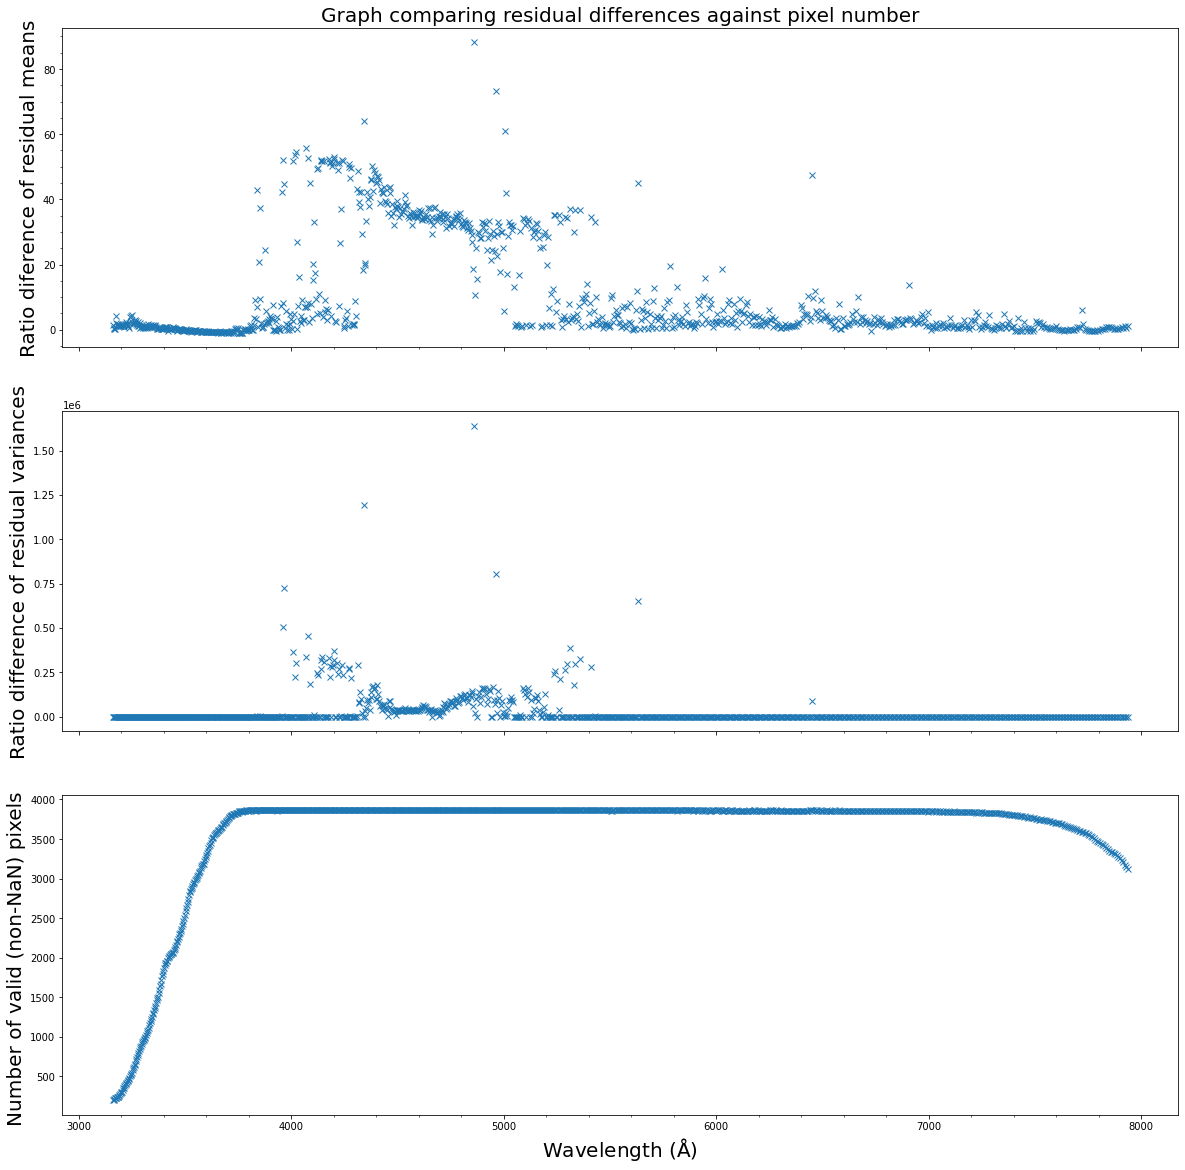

In [42]:
# %% Plot mean and variance of residuals, and number of valid pixels used
end_num = 200
fig, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True, figsize=(20,20))

ax1.plot(wavelengths, chi_per_pixel_mean_diff,'x')
ax1.minorticks_on()
#axins1 = fig.add_axes([0.29, 0.7, 0.595, 0.15])
#axins1.plot(wavelengths[end_num:],chi_per_pixel_mean_diff[end_num:], 'x')
ax1.set_ylabel("Ratio diference of residual means", fontsize=20)

ax2.plot(wavelengths, chi_per_pixel_var_diff,'x')
#axins2 = fig.add_axes([0.29, 0.43, 0.595, 0.15])
#axins2.plot(wavelengths[end_num:],chi_per_pixel_var_diff[end_num:], 'x')
ax2.set_ylabel("Ratio difference of residual variances", fontsize=20)

ax3.plot(wavelengths, num_validpix_per_pixel, 'x')
ax3.set_ylabel("Number of valid (non-NaN) pixels ", fontsize=20)
ax3.set_xlabel(r'${\rm Wavelength\ (\AA)}$', fontsize=20)
ax1.set_title('Graph comparing residual differences against pixel number', fontsize=20)
plt.show()

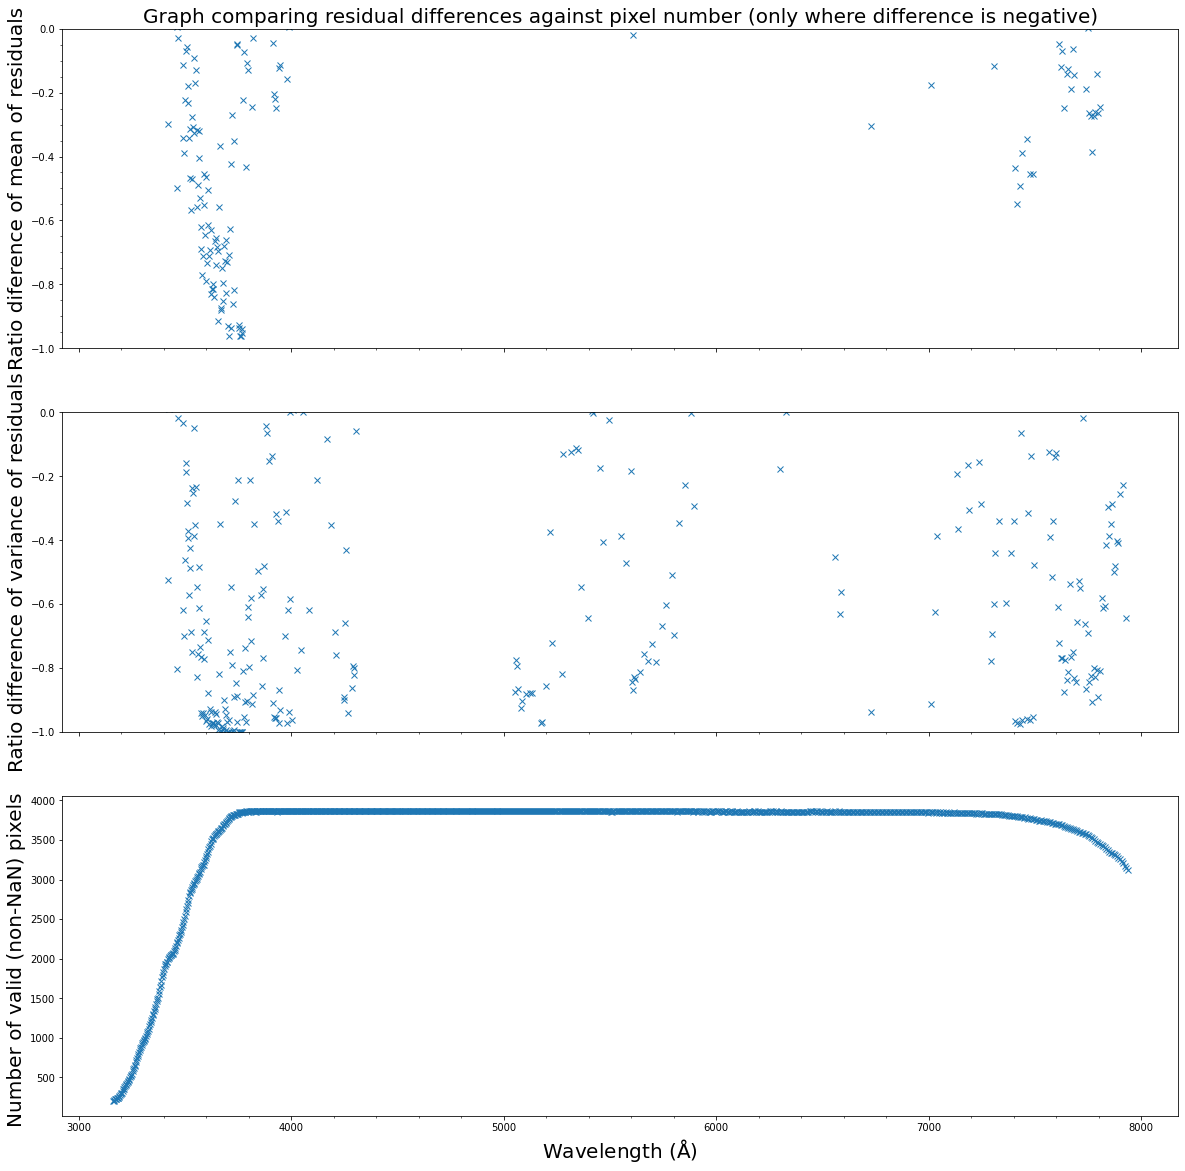

In [43]:
# %% Plot mean and variance of residuals, and number of valid pixels used
end_num = 200
fig, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True, figsize=(20,20))

ax1.plot(wavelengths, chi_per_pixel_mean_diff,'x')
ax1.minorticks_on()
#axins1 = fig.add_axes([0.29, 0.7, 0.595, 0.15])
#axins1.plot(wavelengths[end_num:],chi_per_pixel_mean_diff[end_num:], 'x')
ax1.set_ylabel("Ratio diference of mean of residuals", fontsize=20)
ax1.set_ylim(-1,0)

ax2.plot(wavelengths, chi_per_pixel_var_diff,'x')
#axins2 = fig.add_axes([0.29, 0.43, 0.595, 0.15])
#axins2.plot(wavelengths[end_num:],chi_per_pixel_var_diff[end_num:], 'x')
ax2.set_ylabel("Ratio difference of variance of residuals", fontsize=20)
ax2.set_ylim(-1,0)

ax3.plot(wavelengths, num_validpix_per_pixel, 'x')
ax3.set_ylabel("Number of valid (non-NaN) pixels ", fontsize=20)
ax3.set_xlabel(r'${\rm Wavelength\ (\AA)}$', fontsize=20)
ax1.set_title('Graph comparing residual differences against pixel number (only where difference is negative)', fontsize=20)
plt.show()

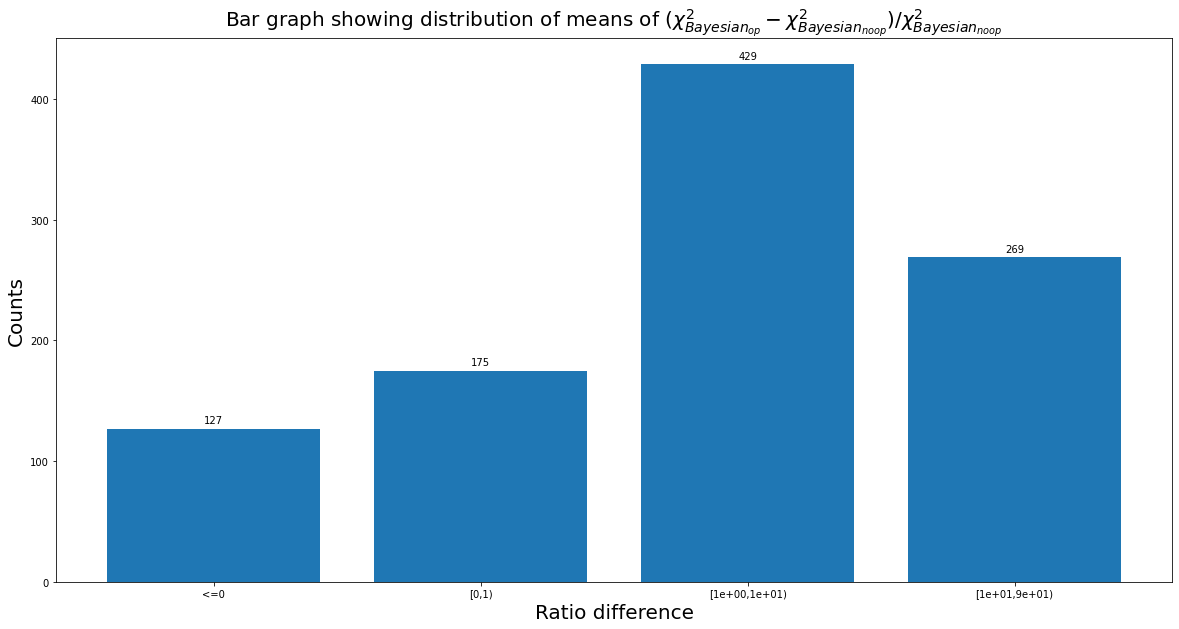

In [94]:
residual_mean_diff_dict = plot_chi_change_bar_log(chi_per_pixel_mean_diff, title='means of $(\chi^2_{Bayesian_{op}} - \chi^2_{Bayesian_{noop}})/\chi^2_{Bayesian_{noop}}$')

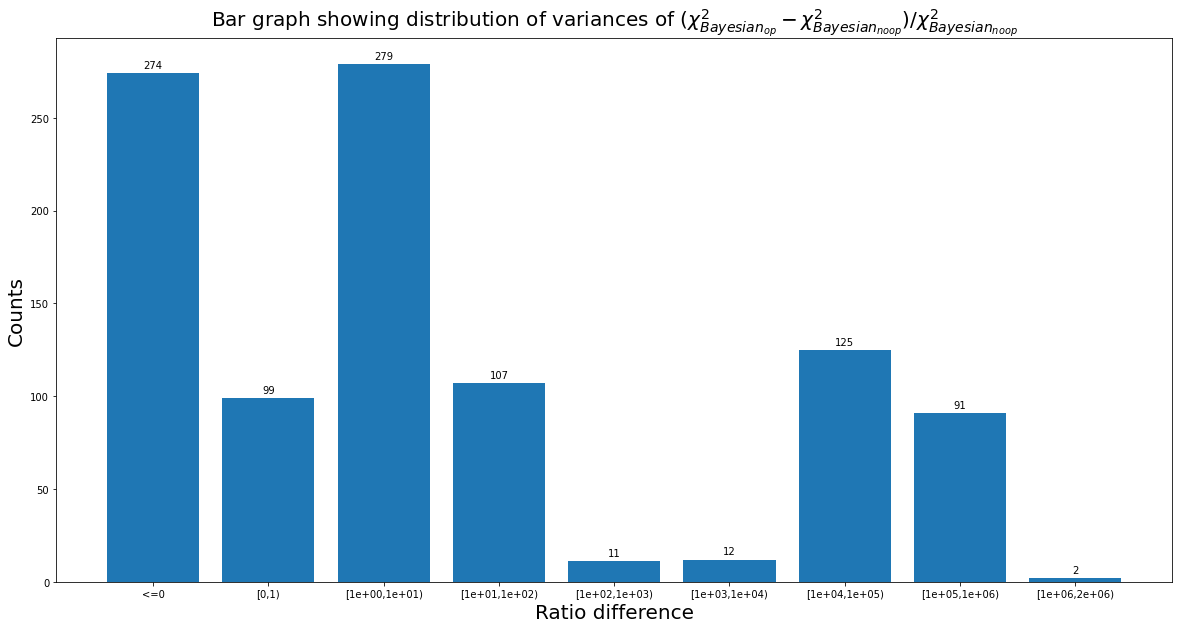

In [95]:
residual_var_dict = plot_chi_change_bar_log(chi_per_pixel_var_diff, title='variances of $(\chi^2_{Bayesian_{op}} - \chi^2_{Bayesian_{noop}})/\chi^2_{Bayesian_{noop}}$')

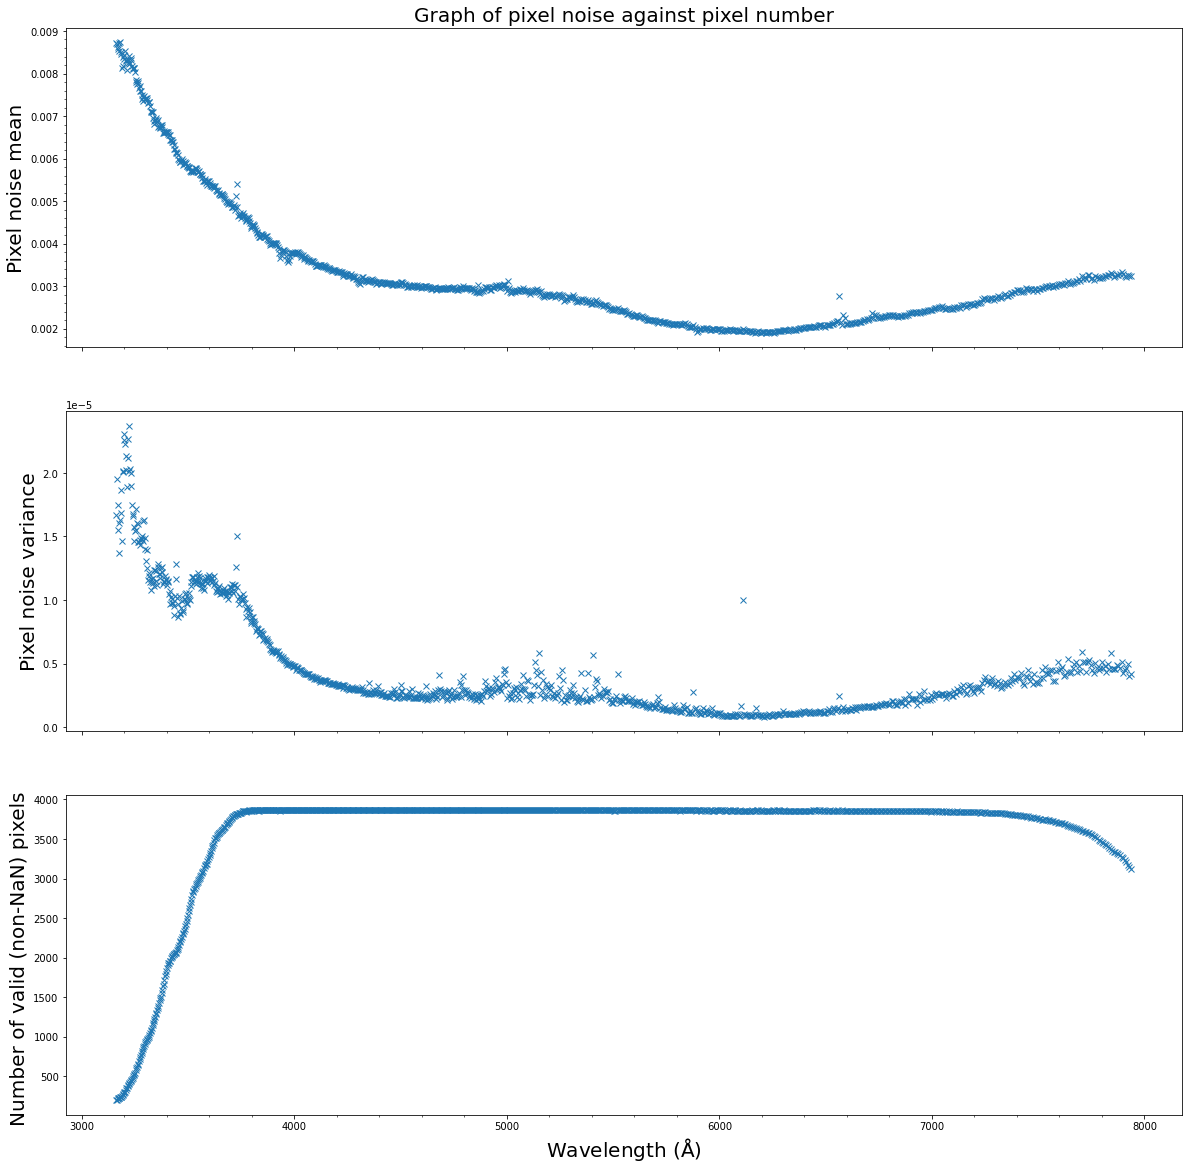

In [46]:
# Plotting errors
# %% Plot mean and variance of residuals, and number of valid pixels used
end_num = 200
fig, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True, figsize=(20,20))

ax1.plot(wavelengths, np.nanmean(spec_err_norm,axis=0),'x')
ax1.minorticks_on()
#axins1 = fig.add_axes([0.29, 0.7, 0.595, 0.15])
#axins1.plot(wavelengths[end_num:],chi_per_pixel_mean_diff[end_num:], 'x')
ax1.set_ylabel("Pixel noise mean", fontsize=20)

ax2.plot(wavelengths, np.nanvar(spec_err_norm,axis=0),'x')
#axins2 = fig.add_axes([0.29, 0.43, 0.595, 0.15])
#axins2.plot(wavelengths[end_num:],chi_per_pixel_var_diff[end_num:], 'x')
ax2.set_ylabel("Pixel noise variance", fontsize=20)

ax3.plot(wavelengths, num_validpix_per_pixel, 'x')
ax3.set_ylabel("Number of valid (non-NaN) pixels ", fontsize=20)
ax3.set_xlabel(r'${\rm Wavelength\ (\AA)}$', fontsize=20)
ax1.set_title('Graph of pixel noise against pixel number', fontsize=20)
plt.show()

## Chi squared for iterative PCA

In [47]:
chi_iterative = calculate_allchi(X_norm_zeros, mu_iter, coeffs, evecs[:n_ev], spec_err_norm)

In [51]:
chi_per_spectra_iterative = np.nansum(chi_iterative, axis=1)/np.count_nonzero(~np.isnan(chi_iterative), axis=1)

In [53]:
chi_per_pixel_mean_iterative = np.nanmean(chi_iterative ** 0.5, axis=0)
chi_per_pixel_var_iterative = np.nanvar(chi_iterative ** 0.5, axis=0)

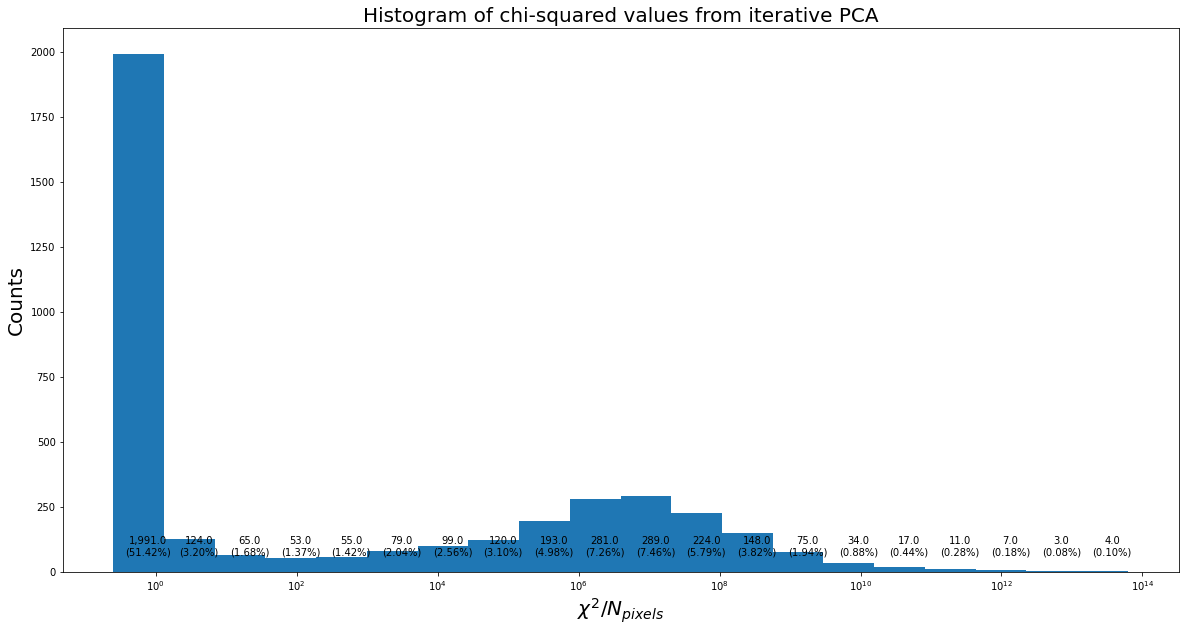

In [56]:
# %% Plot chi-squared values
# Code adapted from https://towardsdatascience.com/advanced-histogram-using-python-bceae288e715
fig, ax = plt.subplots(figsize=(20,10))
_, bins = np.histogram(chi_per_spectra_iterative, bins=20)

# Plot histogram on log scale
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
logcounts, _, _ = ax.hist(chi_per_spectra_iterative, bins=logbins)
ax.set_xscale('log')
        
# Calculate bar centre to display the count of data points and %
bin_x_centers = 0.5 * np.diff(logbins) + logbins[:-1]
bin_y_centers = ax.get_yticks()[1] * 0.25

# Display the the count of data points and % for each bar in histogram
for i in range(len(bins)-1):
    bin_label = "{0:,}".format(logcounts[i]) + "\n({0:,.2f}%)".format((logcounts[i]/logcounts.sum())*100)    
    ax.text(bin_x_centers[i], bin_y_centers, bin_label, horizontalalignment='center')    

plt.title('Histogram of chi-squared values from iterative PCA', fontsize=20)
plt.xlabel("$\chi^2/N_{pixels}$", fontsize=20)
plt.ylabel('Counts',fontsize=20)
plt.show()

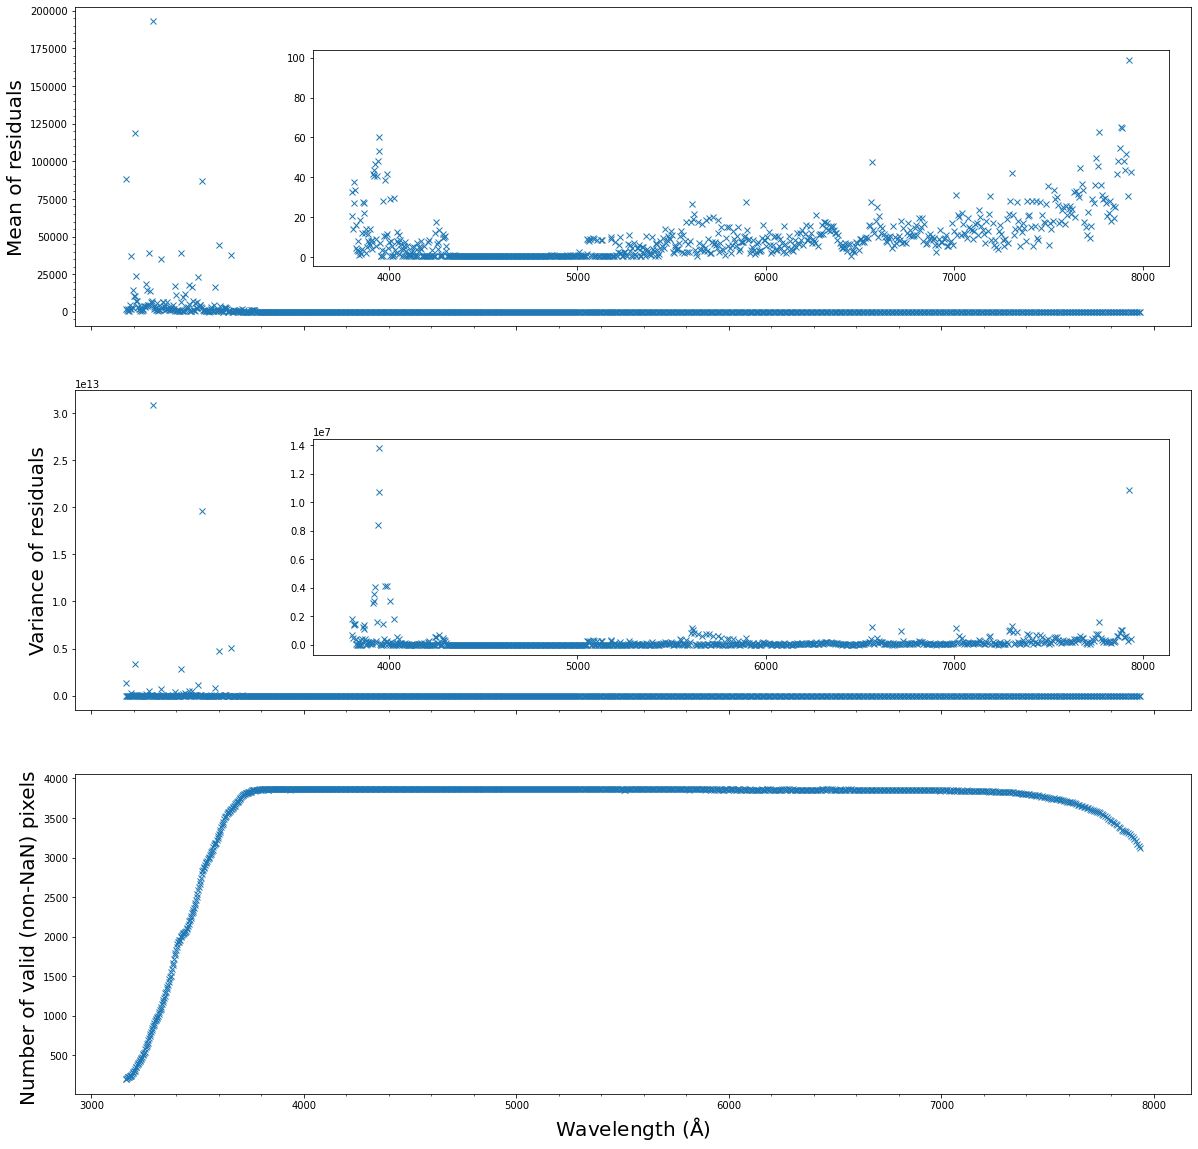

In [57]:
# %% Plot mean and variance of residuals, and number of valid pixels used
end_num = 200
fig, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True, figsize=(20,20))

ax1.plot(wavelengths, chi_per_pixel_mean_iterative ,'x')
ax1.minorticks_on()
axins1 = fig.add_axes([0.29, 0.7, 0.595, 0.15])
axins1.plot(wavelengths[end_num:],chi_per_pixel_mean_iterative[end_num:], 'x')
ax1.set_ylabel("Mean of residuals", fontsize=20)

ax2.plot(wavelengths,chi_per_pixel_var_iterative,'x')
axins2 = fig.add_axes([0.29, 0.43, 0.595, 0.15])
axins2.plot(wavelengths[end_num:],chi_per_pixel_var_iterative[end_num:], 'x')
ax2.set_ylabel("Variance of residuals", fontsize=20)

ax3.plot(wavelengths, num_validpix_per_pixel, 'x')
ax3.set_ylabel("Number of valid (non-NaN) pixels ", fontsize=20)
ax3.set_xlabel(r'${\rm Wavelength\ (\AA)}$', fontsize=20)
plt.show()

## Comparing change in chi-squared values for standard vs iterative PCA

In [60]:
chi_standard = calculate_allchi(X_norm_zeros, pca.mean_, X_red, pca.components_, spec_err_norm)

In [61]:
chi_per_spectra_standard = np.nansum(chi_standard, axis=1)/np.count_nonzero(~np.isnan(chi_standard), axis=1)

In [62]:
chi_per_pixel_mean_standard = np.nanmean(chi_standard ** 0.5, axis=0)
chi_per_pixel_var_standard = np.nanvar(chi_standard ** 0.5, axis=0)

In [63]:
chi_percent_diff_standard_iterative = (chi_per_spectra_iterative-chi_per_spectra_standard)/chi_per_spectra_standard

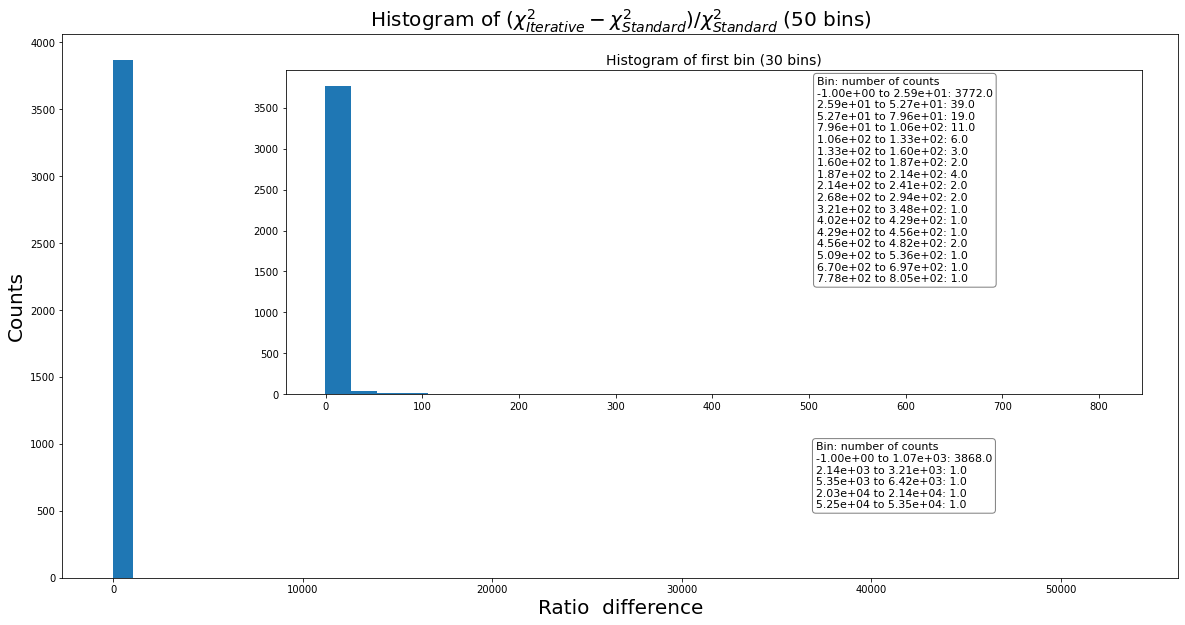

In [96]:
fig, ax = plt.subplots(figsize=(20,10))
counts, bins, _ = ax.hist(chi_percent_diff_standard_iterative, bins=50)
text = 'Bin: number of counts\n'
for i in range(len(bins)-1):
    if counts[i]!= 0:
      text += f'{bins[i]:.2e} to {bins[i+1]:.2e}: {counts[i]}\n'
text = text[:-1]
ax.text(0.675, 0.25, text, transform=ax.transAxes, fontsize=11, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
axins = fig.add_axes([0.28, 0.38, 0.595, 0.45])
counts_axins, bins_axins, _ = axins.hist(chi_percent_diff_standard_iterative[chi_percent_diff_standard_iterative < bins[1]], bins=30)
text_axins = 'Bin: number of counts\n'
for i in range(len(bins_axins)-1):
    if counts_axins[i]!= 0:
      text_axins += f'{bins_axins[i]:.2e} to {bins_axins[i+1]:.2e}: {counts_axins[i]}\n'
text_axins = text_axins[:-1]
axins.text(0.62, 0.98, text_axins, transform=axins.transAxes, fontsize=11, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
axins.set_title('Histogram of first bin (30 bins)', fontsize=14)
ax.set_title('Histogram of $(\chi^2_{Iterative} - \chi^2_{Standard})/\chi^2_{Standard}$ (50 bins)', fontsize=20)
ax.set_xlabel('Ratio  difference', fontsize=20)
ax.set_ylabel('Counts', fontsize=20)
plt.show()

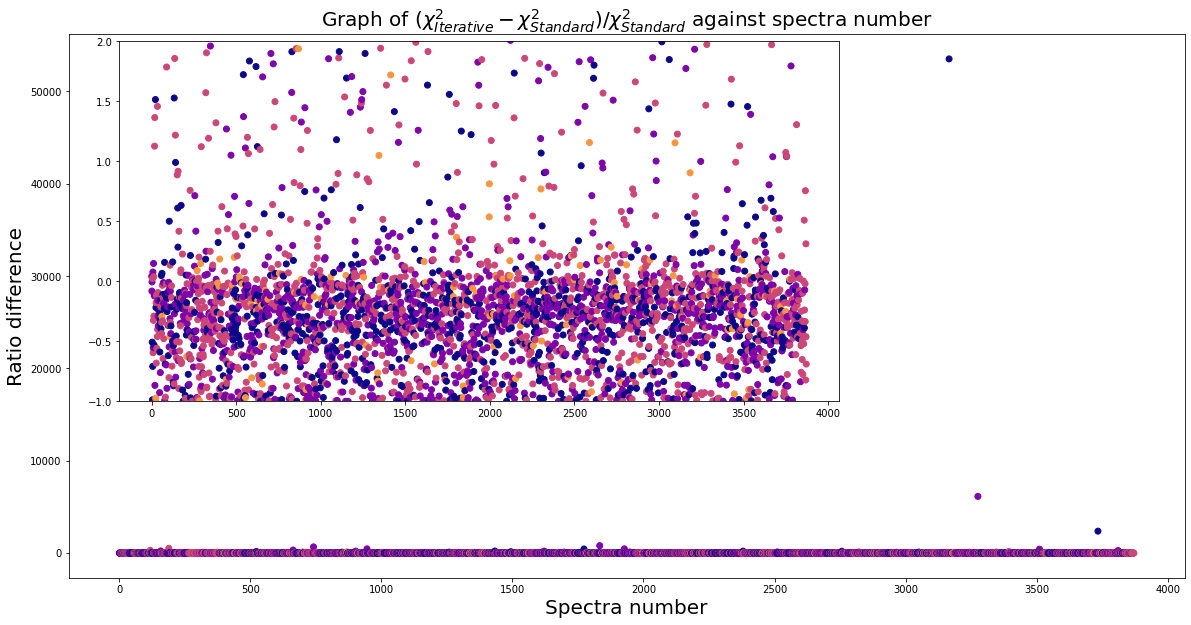

In [65]:
fig, ax = plt.subplots(figsize=(20,10))
ax.scatter(np.arange(len(chi_per_spectra_standard)), chi_percent_diff_standard_iterative, c=subclass, vmin=2, vmax=6)
axins = fig.add_axes([0.16, 0.37, 0.5, 0.5])
axins.scatter(np.arange(len(chi_per_spectra_standard)), chi_percent_diff_standard_iterative, c=subclass, vmin=2, vmax=6)
axins.set_ylim(-1,2)
ax.set_xlabel('Spectra number', fontsize=20)
ax.set_ylabel('Ratio difference', fontsize=20)
ax.set_title('Graph of $(\chi^2_{Iterative} - \chi^2_{Standard})/\chi^2_{Standard}$ against spectra number', fontsize=20)
plt.show()

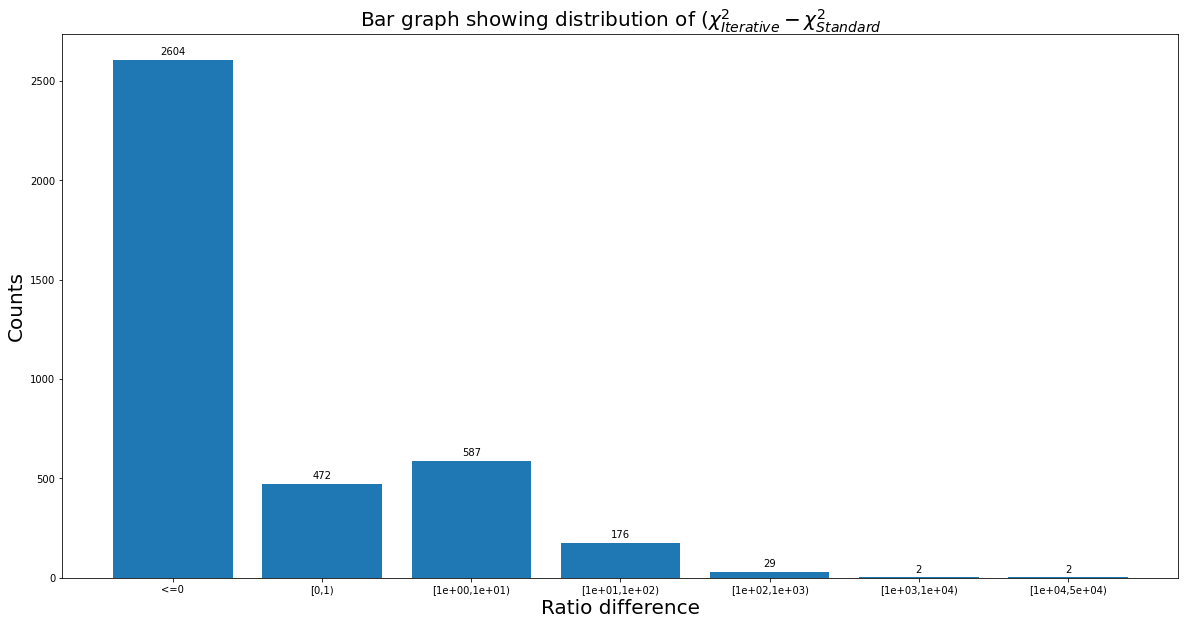

In [97]:
chi_percent_diff_dict_standard_iterative = plot_chi_change_bar_log(chi_percent_diff_standard_iterative, title='$(\chi^2_{Iterative} - \chi^2_{Standard}})/\chi^2_{Standard}$')

In [99]:
chi_per_pixel_mean_diff_standard_iterative = (chi_per_pixel_mean_iterative-chi_per_pixel_mean_standard)/chi_per_pixel_mean_standard
chi_per_pixel_var_diff_standard_iterative = (chi_per_pixel_var_iterative-chi_per_pixel_var_standard)/chi_per_pixel_var_standard

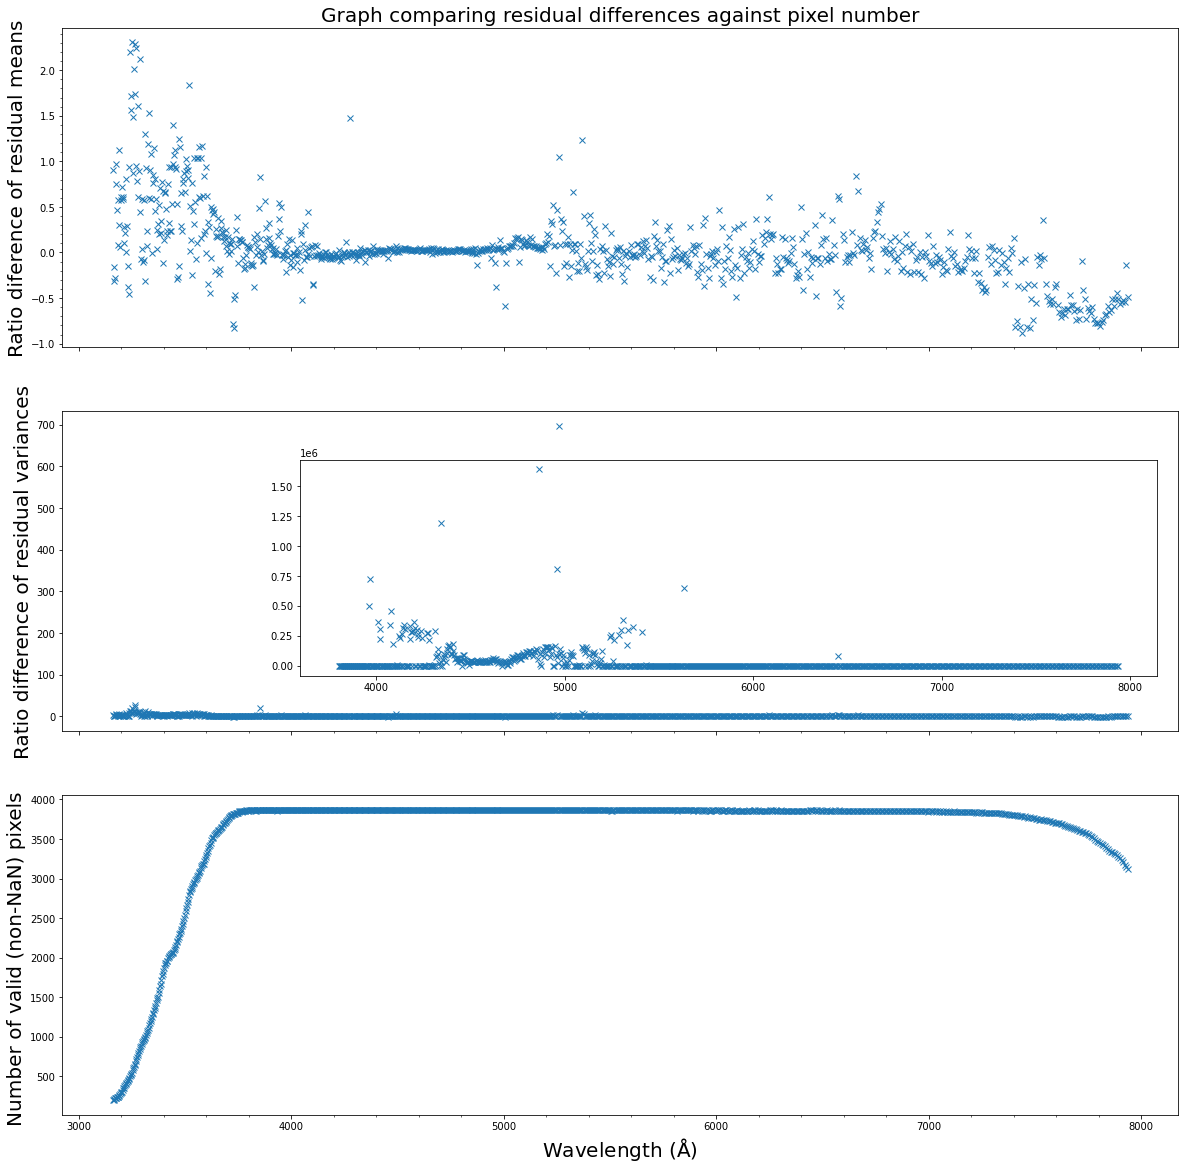

In [101]:
# %% Plot mean and variance of residuals, and number of valid pixels used
end_num = 200
fig, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True, figsize=(20,20))

ax1.plot(wavelengths, chi_per_pixel_mean_diff_standard_iterative,'x')
ax1.minorticks_on()
#axins1 = fig.add_axes([0.29, 0.7, 0.595, 0.15])
#axins1.plot(wavelengths[end_num:],chi_per_pixel_mean_diff[end_num:], 'x')
ax1.set_ylabel("Ratio diference of residual means", fontsize=20)

ax2.plot(wavelengths, chi_per_pixel_var_diff_standard_iterative,'x')
axins2 = fig.add_axes([0.29, 0.43, 0.595, 0.15])
axins2.plot(wavelengths[end_num:],chi_per_pixel_var_diff[end_num:], 'x')
ax2.set_ylabel("Ratio difference of residual variances", fontsize=20)

ax3.plot(wavelengths, num_validpix_per_pixel, 'x')
ax3.set_ylabel("Number of valid (non-NaN) pixels ", fontsize=20)
ax3.set_xlabel(r'${\rm Wavelength\ (\AA)}$', fontsize=20)
ax1.set_title('Graph comparing residual differences against pixel number', fontsize=20)
plt.show()

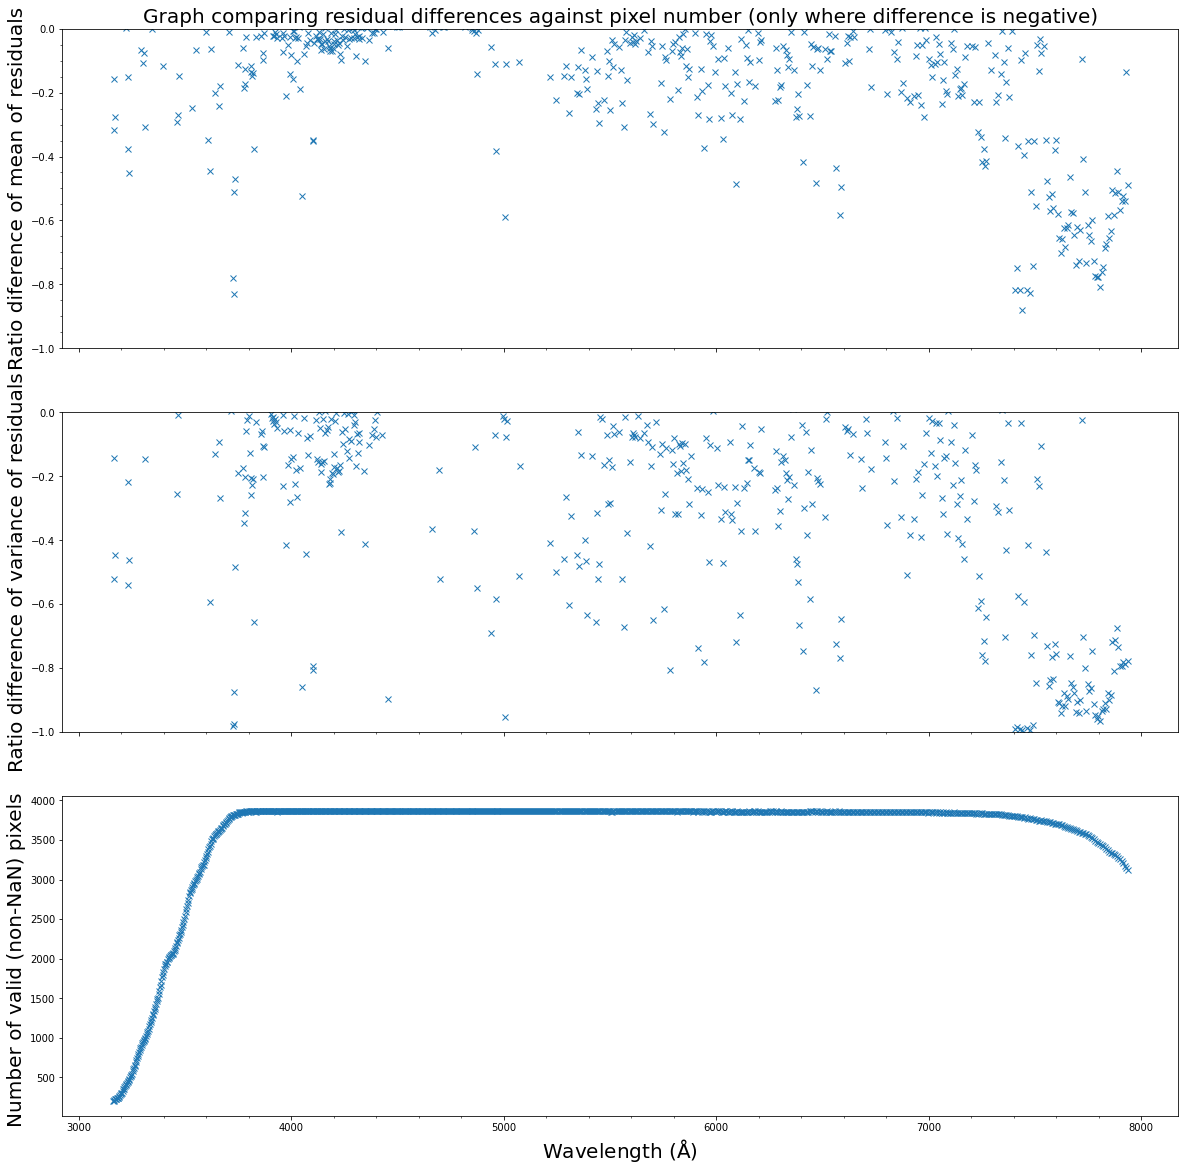

In [102]:
# %% Plot mean and variance of residuals, and number of valid pixels used
end_num = 200
fig, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True, figsize=(20,20))

ax1.plot(wavelengths, chi_per_pixel_mean_diff_standard_iterative,'x')
ax1.minorticks_on()
#axins1 = fig.add_axes([0.29, 0.7, 0.595, 0.15])
#axins1.plot(wavelengths[end_num:],chi_per_pixel_mean_diff[end_num:], 'x')
ax1.set_ylabel("Ratio diference of mean of residuals", fontsize=20)
ax1.set_ylim(-1,0)

ax2.plot(wavelengths, chi_per_pixel_var_diff_standard_iterative,'x')
#axins2 = fig.add_axes([0.29, 0.43, 0.595, 0.15])
#axins2.plot(wavelengths[end_num:],chi_per_pixel_var_diff[end_num:], 'x')
ax2.set_ylabel("Ratio difference of variance of residuals", fontsize=20)
ax2.set_ylim(-1,0)

ax3.plot(wavelengths, num_validpix_per_pixel, 'x')
ax3.set_ylabel("Number of valid (non-NaN) pixels ", fontsize=20)
ax3.set_xlabel(r'${\rm Wavelength\ (\AA)}$', fontsize=20)
ax1.set_title('Graph comparing residual differences against pixel number (only where difference is negative)', fontsize=20)
plt.show()

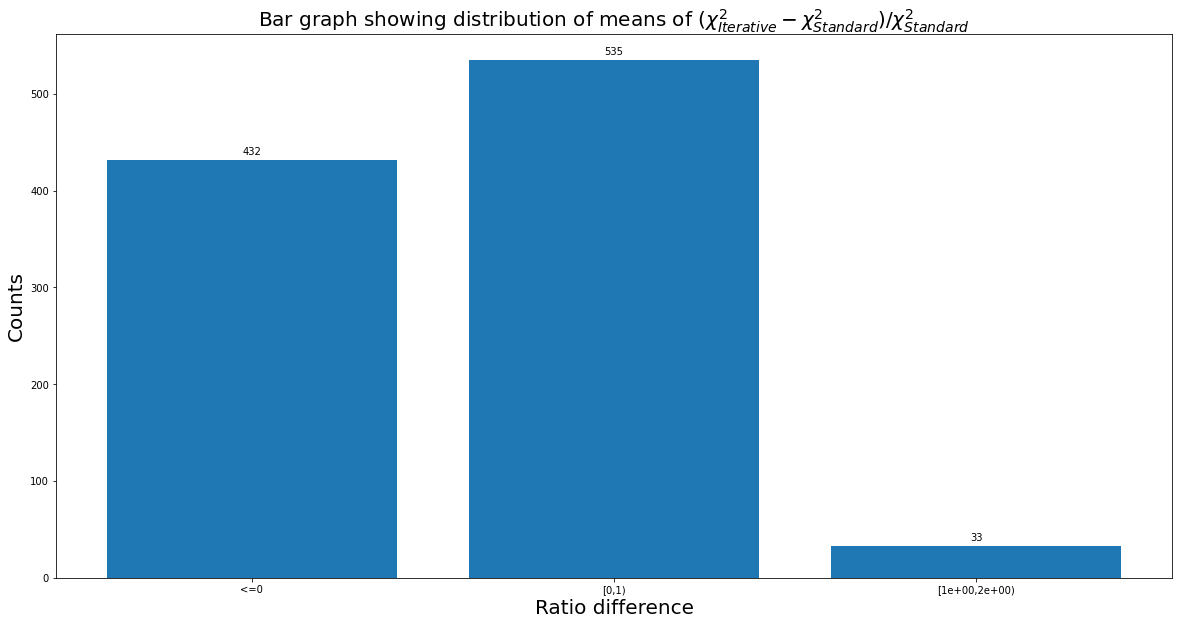

In [103]:
residual_mean_diff_dict_standard_iterative = plot_chi_change_bar_log(chi_per_pixel_mean_diff_standard_iterative, title='means of $(\chi^2_{Iterative} - \chi^2_{Standard})/\chi^2_{Standard}$')

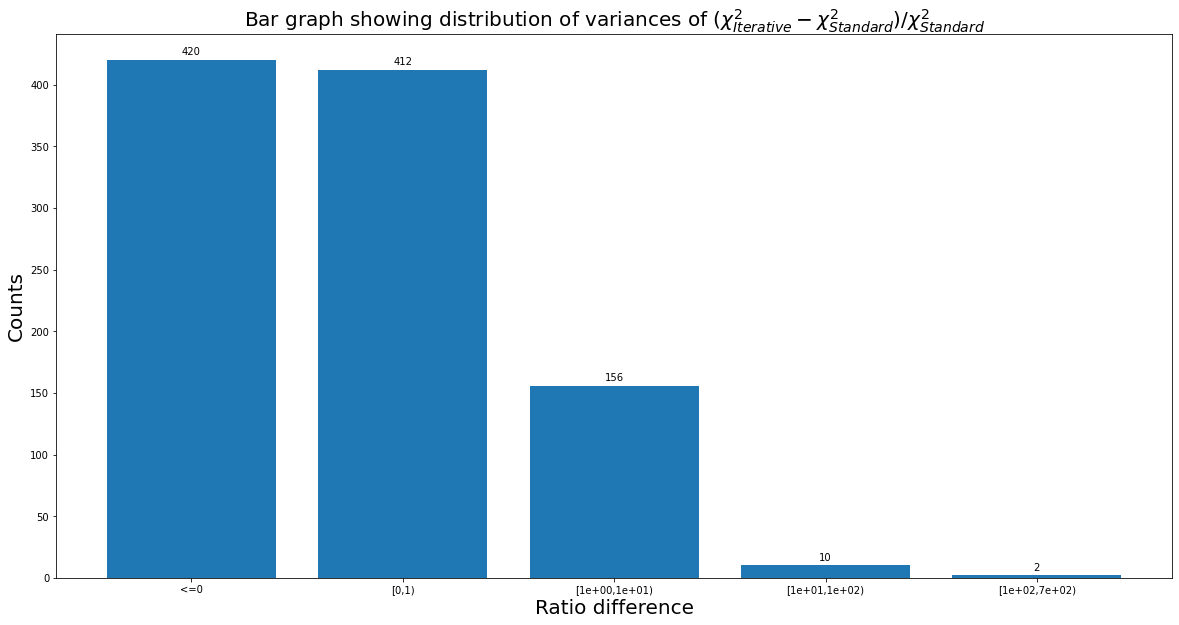

In [104]:
residual_var_dict_standard_iterative = plot_chi_change_bar_log(chi_per_pixel_var_diff_standard_iterative, title='variances of $(\chi^2_{Iterative} - \chi^2_{Standard})/\chi^2_{Standard}$')